# ISYE-6420 - Final Project - My Own Bayesian Data Analysis - Steam Games Dataset

# Imports


In [132]:
# Basic imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotnine as pn
from tqdm import tqdm
from datetime import datetime
import pickle
import cloudpickle                # Vanilla pickle does not work when saving PyMC models
import re
from copy import copy

# Bayesian modeling imports
import pymc as pm
import arviz as az

# Scikit-learn data preprocesisng imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder

# For embedding reviews and game descriptions
from transformers import DistilBertTokenizer, DistilBertModel
import torch

# Scikit-learn modeling imports
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

# Scikit-learn model evaluation imports
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer

# Mount Drive

In [133]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Global Configurations

In [134]:
ASSIGNMENT_SEEDS = [
    1,
    42,
    16163,              # Undergrad ID
    3905474,            # Another undergrad ID
    93956081            # Grad ID
]

TEST_SET_SIZE = 0.2
N_CV = 5
EXPERIMENT_SEED = 93956081

# Directory Setup

In [135]:
# Working directory is ROOT_DIR/ASSIGNMENT_DIR
ROOT_DIR = '/content/drive/MyDrive/'
ASSIGNMENT_DIR = 'isye_6420_final_project_steam_games'

# Assignment dir has one folder for each of data, frequentist model artifacts,
# bayesian model artifacts, and final results
ASSIGNMENT_SUBDIRS = ['data', 'frequentist', 'bayesian', 'results']

In [136]:
WORKING_DIR = os.path.join(ROOT_DIR, ASSIGNMENT_DIR)
os.makedirs(WORKING_DIR, exist_ok = True)

os.chdir(WORKING_DIR)

[os.makedirs(os.path.join(WORKING_DIR, x), exist_ok = True) for x in ASSIGNMENT_SUBDIRS]

[None, None, None, None]

# Data Preprocessing

## Reading Data

In [ ]:
raw_data = pd.read_csv("./data/games.csv")

In [ ]:
# For ease of processing, convert all columns to lowercase
raw_data.columns = [str.lower(x) for x in raw_data.columns.tolist()]

In [ ]:
raw_data.shape

(85103, 39)

In [ ]:
raw_data.head()

,appid,name,release date,estimated owners,peak ccu,required age,price,dlc count,about the game,supported languages,...,average playtime two weeks,median playtime forever,median playtime two weeks,developers,publishers,categories,genres,tags,screenshots,movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],...,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",...,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",...,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",...,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85103 entries, 0 to 85102
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   appid                       85103 non-null  int64  
 1   name                        85097 non-null  object 
 2   release date                85103 non-null  object 
 3   estimated owners            85103 non-null  object 
 4   peak ccu                    85103 non-null  int64  
 5   required age                85103 non-null  int64  
 6   price                       85103 non-null  float64
 7   dlc count                   85103 non-null  int64  
 8   about the game              81536 non-null  object 
 9   supported languages         85103 non-null  object 
 10  full audio languages        85103 non-null  object 
 11  reviews                     9743 non-null   object 
 12  header image                85103 non-null  object 
 13  website                     394

In [ ]:
raw_data.describe()

,appid,peak ccu,required age,price,dlc count,metacritic score,user score,positive,negative,score rank,achievements,recommendations,average playtime forever,average playtime two weeks,median playtime forever,median playtime two weeks
count,8.510300e+04,85103.000000,85103.000000,85103.000000,85103.000000,85103.000000,85103.000000,8.510300e+04,85103.000000,44.000000,85103.000000,8.510300e+04,85103.000000,85103.000000,85103.000000,85103.000000
mean,1.355681e+06,134.872930,0.312774,7.193703,0.543412,3.348366,0.039822,9.585609e+02,159.772570,98.909091,19.859394,7.755176e+02,104.729681,10.680105,93.316029,11.467328
std,6.949952e+05,5403.548851,2.254721,12.362478,13.721223,15.421471,1.791013,2.435920e+04,4574.583903,0.857747,171.446874,1.789338e+04,1142.447517,188.840006,1510.732101,205.372944
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,97.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,7.723900e+05,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,98.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,1.331540e+06,0.000000,0.000000,4.490000,0.000000,0.000000,0.000000,7.000000e+00,2.000000,99.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,1.918415e+06,1.000000,0.000000,9.990000,0.000000,0.000000,0.000000,4.500000e+01,14.000000,100.000000,18.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
max,2.765800e+06,872138.000000,21.000000,999.980000,2366.000000,97.000000,100.000000,5.764420e+06,895978.000000,100.000000,9821.000000,3.441592e+06,145727.000000,19159.000000,208473.000000,19159.000000


## Typecasting

In [ ]:
raw_data['release_datetime'] = pd.to_datetime(raw_data['release date'], format = 'mixed')

In [ ]:
raw_data['price'] = raw_data['price'].astype('float')

## Filtering

We have way too many games. It might be more tractable to filter them down to fewer observations.

In [ ]:
raw_data['release_datetime'].min()

Timestamp('1997-06-30 00:00:00')

In [ ]:
raw_data['release_datetime'].max()

Timestamp('2025-04-14 00:00:00')

In [ ]:
# Try considering more recent games from a time when Steam became relevant as a marketplace
release_start_date = pd.to_datetime('2010-01-01')
filtered_data = raw_data.loc[raw_data['release_datetime'] >= release_start_date]

In [ ]:
raw_data.shape

(85103, 40)

In [ ]:
# Not a huge effect on the number of observations
filtered_data.shape

(84376, 40)

If we want to predict game ratings, we ideally want some variance in the data.

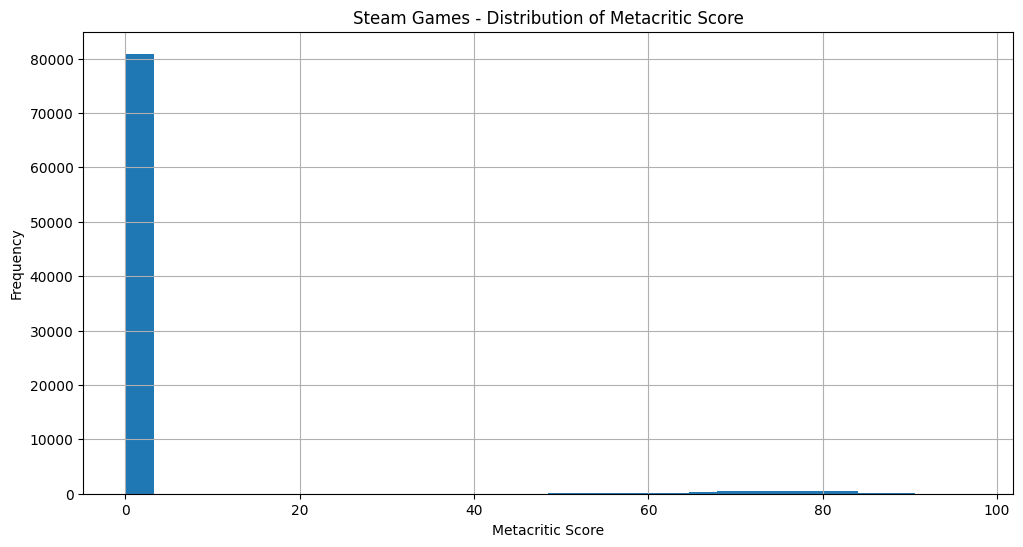

In [ ]:
filtered_data['metacritic score'].plot(kind = 'hist', grid = True, bins = 30, figsize = (12, 6))
plt.xlabel('Metacritic Score'); plt.ylabel('Frequency'); plt.title('Steam Games - Distribution of Metacritic Score');

This suggests the vast majority of the games do not have a rating. We could try to model this as a zero-inflated mixture model, but for more interesting analysis into the dynamics of games and their ratings, focus on all games that have non-zero ratings.

In [ ]:
filtered_data = filtered_data.loc[filtered_data['metacritic score'] > 0]

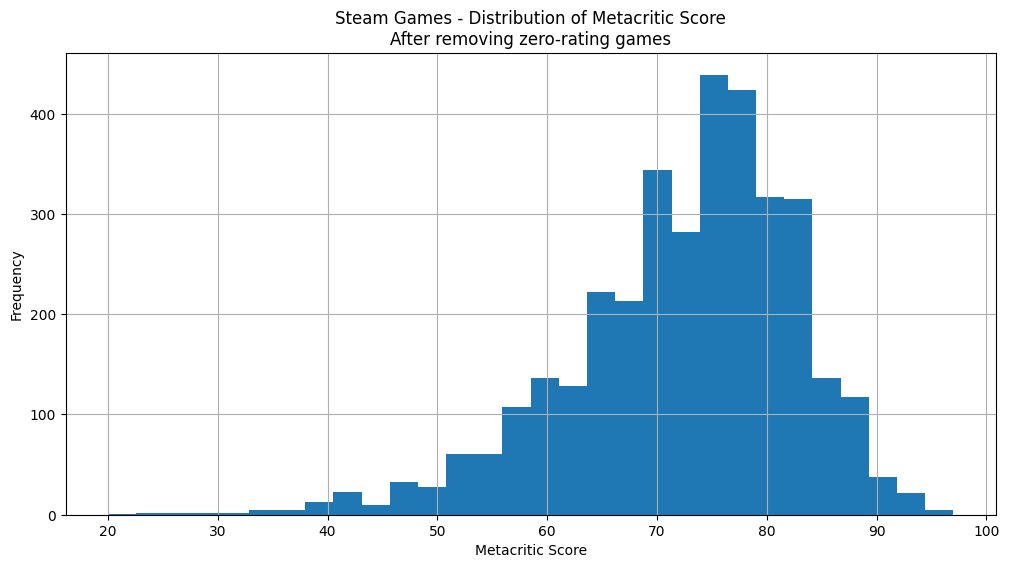

In [ ]:
filtered_data['metacritic score'].plot(kind = 'hist', grid = True, bins = 30, figsize = (12, 6))
plt.xlabel('Metacritic Score'); plt.ylabel('Frequency'); plt.title('Steam Games - Distribution of Metacritic Score\nAfter removing zero-rating games');

This has a significant effect on the number of observations in the dataset.

# Feature Engineering

## Release Year

In [ ]:
filtered_data['release_year'] = filtered_data['release_datetime'].dt.year.astype(int)

## Extracting multi-string features

In [ ]:
def extract_category_count(x, delimiter):
  split_x = str(x).split(delimiter)
  return len(split_x)

In [ ]:
filtered_data.columns

Index(['appid', 'name', 'release date', 'estimated owners', 'peak ccu',
       'required age', 'price', 'dlc count', 'about the game',
       'supported languages', 'full audio languages', 'reviews',
       'header image', 'website', 'support url', 'support email', 'windows',
       'mac', 'linux', 'metacritic score', 'metacritic url', 'user score',
       'positive', 'negative', 'score rank', 'achievements', 'recommendations',
       'notes', 'average playtime forever', 'average playtime two weeks',
       'median playtime forever', 'median playtime two weeks', 'developers',
       'publishers', 'categories', 'genres', 'tags', 'screenshots', 'movies',
       'release_datetime', 'release_year'],
      dtype='object')

In [ ]:
filtered_data['n_supported_languages'] = filtered_data['supported languages'].apply(lambda x: extract_category_count(x, ', '))

In [ ]:
filtered_data['n_audio_languages'] = filtered_data['full audio languages'].apply(lambda x: extract_category_count(x, ', '))

In [ ]:
filtered_data['n_genres'] = filtered_data['genres'].apply(lambda x: extract_category_count(x, ','))

In [ ]:
filtered_data['n_tags'] = filtered_data['tags'].apply(lambda x: extract_category_count(x, ','))

In [ ]:
filtered_data['n_developers'] = filtered_data['developers'].apply(lambda x: extract_category_count(x, ','))

In [ ]:
filtered_data['n_publishers'] = filtered_data['publishers'].apply(lambda x: extract_category_count(x, ','))

In [ ]:
filtered_data['n_categories'] = filtered_data['categories'].apply(lambda x: extract_category_count(x, ','))

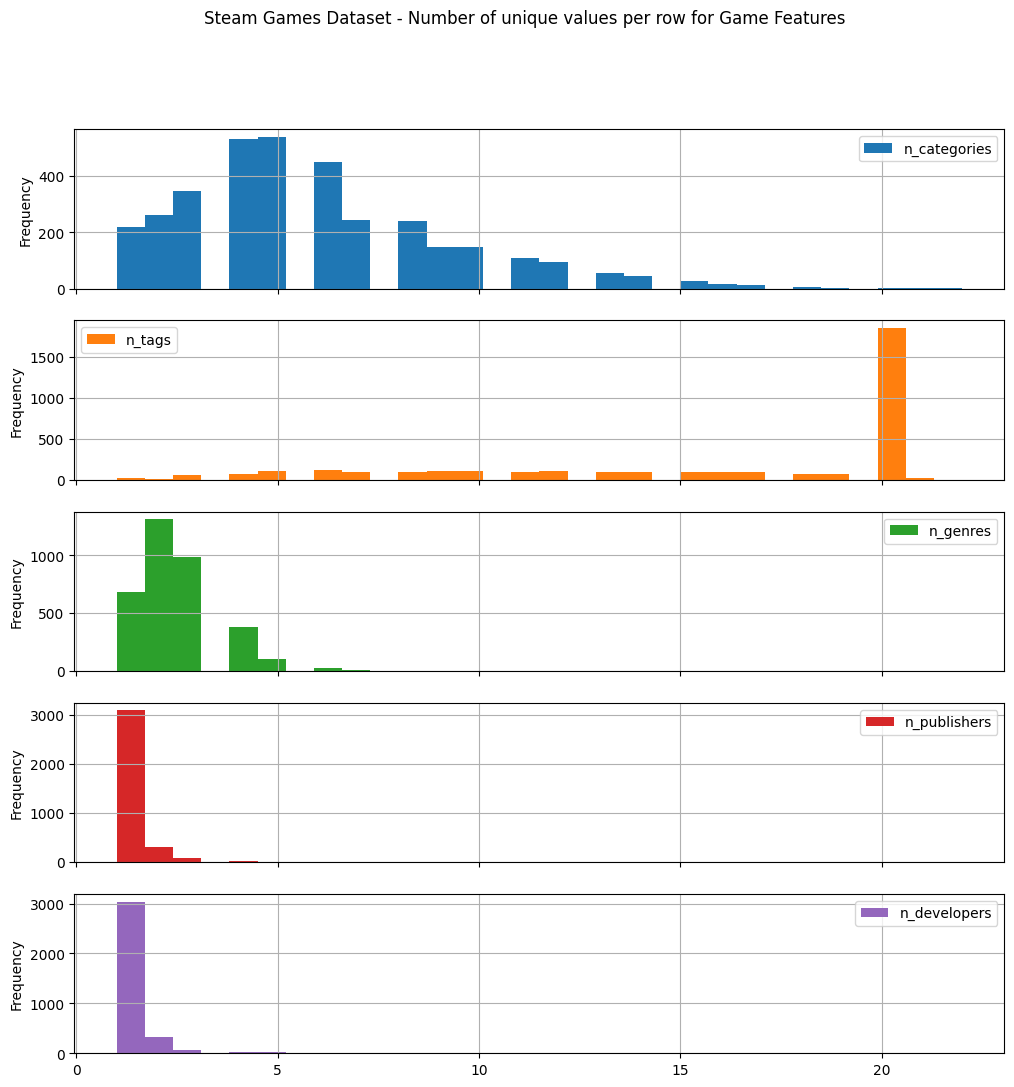

In [ ]:
filtered_data[['n_categories', 'n_tags', 'n_genres',
               'n_publishers', 'n_developers']].plot(
    kind = 'hist', subplots = True, figsize = (12, 12), grid = True, bins = 30
)

plt.suptitle('Steam Games Dataset - Number of unique values per row for Game Features');

This suggests extracting the first occurrence of a publisher and developer may be sufficient for modeling purposes.

However, it may be useful to extract the first three genres for most games.

Most games also have up to 20 tags - one-hot encoding each tag would make modeling computationally infeasible owing to curse of dimensionality.

Likewise, each game seems to be tagged with at least 10 categories. This, too, would lead to high dimensionality.

## Extracting minimum and maximum age

In [ ]:
filtered_data['estimated_owners_lower'] = filtered_data['estimated owners'].apply(lambda x: int(x.split(' - ')[0]))
filtered_data['estimated_owners_upper'] = filtered_data['estimated owners'].apply(lambda x: int(x.split(' - ')[1]))

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>],
      dtype=object)

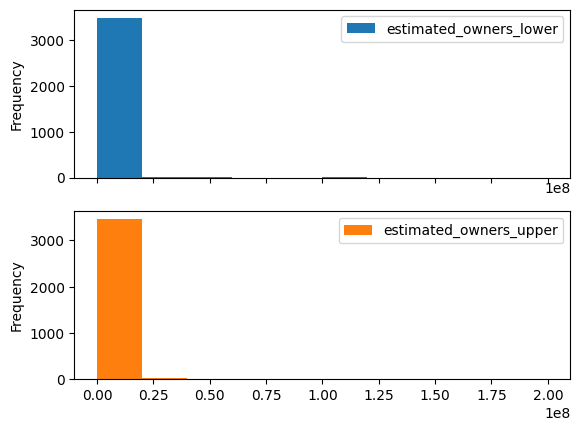

In [ ]:
filtered_data[['estimated_owners_lower', 'estimated_owners_upper']].plot(
    kind = 'hist', subplots = True
)

## Primary Features

In [ ]:
filtered_data['developer_primary'] = filtered_data['developers'].apply(lambda x: str(x).split(",")[0])
filtered_data['developer_primary'].value_counts(ascending = False, normalize = True, dropna = False)

## Primary Genre


In [ ]:
filtered_data['genre_primary'] = filtered_data['genres'].apply(lambda x: str(x).split(",")[0])

In [ ]:
filtered_data['genre_primary'].value_counts(ascending = False, normalize = True, dropna = False)

genre_primary
Action                   0.502433
Adventure                0.233896
Indie                    0.089894
Strategy                 0.043516
Simulation               0.036358
RPG                      0.033782
Casual                   0.031778
Racing                   0.014601
Free to Play             0.008016
Sports                   0.002577
Violent                  0.001718
Sexual Content           0.000573
Massively Multiplayer    0.000573
nan                      0.000286
Name: proportion, dtype: float64

## Reviews

Using pre-trained word embedding followed by PCA and summary statistics to extract sentiment and semantically meaningful data from the description.

### Encoding

In [ ]:
# Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
filtered_data['review_word_count'] = filtered_data['reviews'].apply(lambda x: len(str(x).split(' ')))

In [ ]:
filtered_data['review_word_count'].quantile([0.025, 0.05, 0.25, 0.5, 0.75, 0.975, 0.99])

0.025      1.00
0.050      1.00
0.250      1.00
0.500     29.00
0.750     64.00
0.975    139.00
0.990    171.08
Name: review_word_count, dtype: float64

<Axes: ylabel='Frequency'>

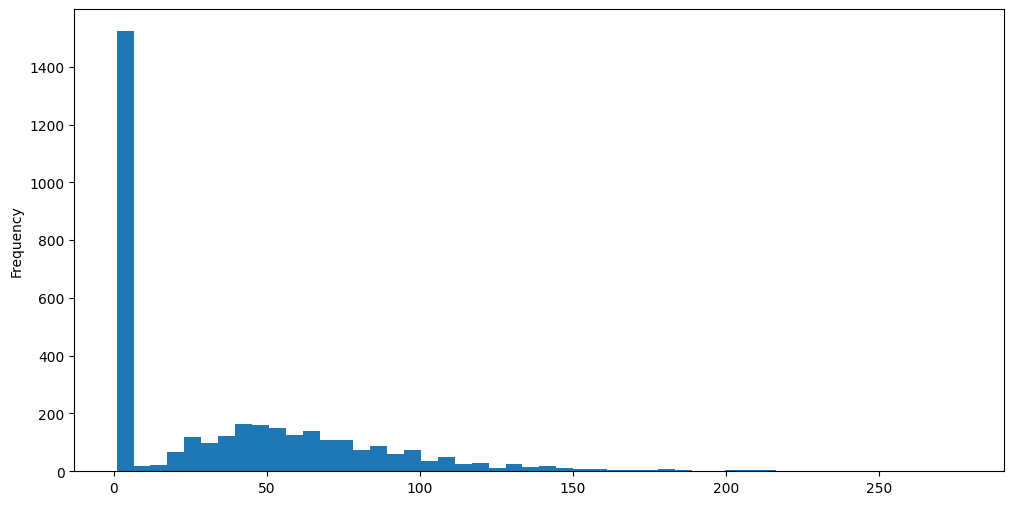

In [ ]:
filtered_data['review_word_count'].plot(kind = 'hist', bins = 50, figsize = (12, 6))

Based on this distribution and the quantile plot, embedding while considering the first 120 words should be sufficient.

In [ ]:
filtered_data.loc[filtered_data['reviews'].isna(), 'reviews'] = ''

In [ ]:
# def encode_text_with_bert(text, max_length = 120):
#     tokens = tokenizer(text, return_tensors='pt', max_length=max_length, truncation=True, padding=True)
#     with torch.no_grad():
#         outputs = model(**tokens)
#     embeddings = outputs.last_hidden_state[:, 0, :]
#     return embeddings

# orig_reviews = filtered_data['reviews']
# embedded_reviews = []
# for review in tqdm(orig_reviews):
#     embedded_review = encode_text_with_bert(review)
#     embedded_reviews.append(embedded_review)

# embedded_reviews_np = [t.numpy() for t in embedded_reviews]
# embedded_reviews_np = np.vstack(embedded_reviews_np)

# Save to disk for later
# with open("./data/embedded_reviews_np.pkl", "wb") as f:
#   pickle.dump(embedded_reviews, f)

In [ ]:
with open("./data/embedded_reviews_np.pkl", "rb") as f:
  embedded_reviews_np = pickle.load(f)

### Embedding Point Estimates

In [ ]:
embedding_reviews_df = pd.DataFrame(embedded_reviews_np)
embedding_reviews_df.columns = [f'review_embed_dim_{i}' for i in embedding_reviews_df.columns]

In [ ]:
embedding_reviews_df['review_embed_mean'] = embedding_reviews_df.mean(axis = 1)
embedding_reviews_df['review_embed_max'] = embedding_reviews_df.max(axis = 1)
embedding_reviews_df['review_embed_sum'] = embedding_reviews_df.sum(axis = 1)

In [ ]:
embedding_reviews_pca_df = embedding_reviews_df.filter(like = 'review_embed_dim')

### Embedding PCA

In [ ]:
def apply_pca_to_embedding(embedding_df, explained_variance_threshold = 0.90):
  # Instantiate a standard scaler to normalize differences across dimensions
  scaled_df = StandardScaler().fit_transform(embedding_df)

  # Fit a PCA model to decrease dimensionality
  pca_dim_red = PCA(n_components = explained_variance_threshold)
  pca_dim_red.fit(scaled_df)
  projected_df = pd.DataFrame(pca_dim_red.transform(scaled_df))

  print(f"{explained_variance_threshold} met with {projected_df.shape[1]} components")
  projected_df.columns = [f'pc_{i}' for i in range(projected_df.shape[1])]

  return projected_df

In [ ]:
embedding_reviews_pca_df = apply_pca_to_embedding(embedding_reviews_pca_df)

0.9 met with 67 components


## Game Description

### Encoding

In [ ]:
filtered_data['game_desc_length'] = filtered_data['about the game'].apply(lambda x: len(str(x).split(' ')))

<Axes: ylabel='Frequency'>

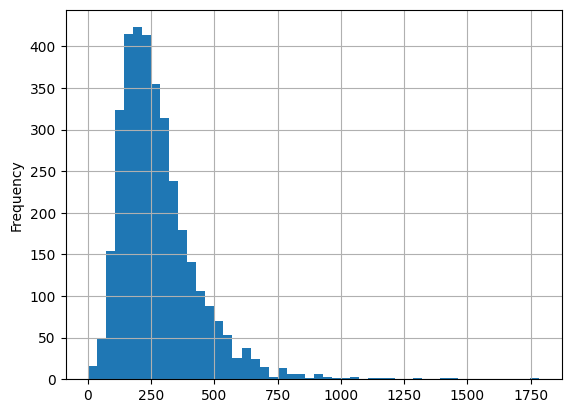

In [ ]:
filtered_data['game_desc_length'].plot(kind = 'hist', bins = 50, grid = True)

In [ ]:
filtered_data['game_desc_length'].quantile([0, 0.025, 0.05, 0.25, 0.75, 0.95, 0.975])

0.000      1.0
0.025     81.0
0.050    100.6
0.250    173.0
0.750    344.0
0.950    555.0
0.975    645.0
Name: game_desc_length, dtype: float64

In [ ]:
filtered_data.loc[filtered_data['about the game'].isna(), 'about the game'] = ''

In [ ]:
# orig_descriptions = filtered_data['about the game']
# embedded_descs = []
# for desc in tqdm(orig_descriptions):
#     try:
#         embedded_desc = encode_text_with_bert(desc, max_length = 500)
#         embedded_descs.append(embedded_desc)
#     except Exception as e:
#         print(f"Error while embedding {desc}")
#         print(e)

# embedded_desc_np = [t.numpy() for t in embedded_descs]
# embedded_desc_np = np.vstack(embedded_desc_np)

# with open("./data/embedded_desc_np.pkl", "wb") as f:
#     pickle.dump(embedded_desc_np, f)

### Embedding Point Estimates

In [ ]:
with open("./data/embedded_desc_np.pkl", "rb") as f:
  embedded_desc_np = pickle.load(f)

In [ ]:
embedding_desc_df = pd.DataFrame(embedded_desc_np)
embedding_desc_df.columns = [f'desc_embed_dim_{i}' for i in embedding_desc_df.columns]

In [ ]:
embedding_desc_df['desc_embed_mean'] = embedding_desc_df.mean(axis = 1)
embedding_desc_df['desc_embed_max'] = embedding_desc_df.max(axis = 1)
embedding_desc_df['desc_embed_sum'] = embedding_desc_df.sum(axis = 1)

### Embedding PCA

In [ ]:
embedding_desc_pca_df = embedding_reviews_df.filter(like = 'desc_embed_dim')
embedding_desc_pca_df = apply_pca_to_embedding(embedding_reviews_pca_df)

0.9 met with 61 components


## Backapplying Embedding Data

In [ ]:
embedding_desc_pca_df.columns = [f'desc_{x}' for x in embedding_desc_pca_df.columns.tolist()]

In [ ]:
embedding_reviews_pca_df.columns = [f'review_{x}' for x in embedding_reviews_pca_df.columns.tolist()]

In [ ]:
processed_data = pd.concat([
    filtered_data.reset_index(),

    embedding_desc_df[['desc_embed_mean', 'desc_embed_max', 'desc_embed_sum']],
    embedding_desc_pca_df.reset_index(),

    embedding_reviews_df[['review_embed_mean', 'review_embed_max', 'review_embed_sum']],
    embedding_reviews_pca_df.reset_index(),
], axis = 1)

In [ ]:
processed_data.shape

(3493, 191)

In [ ]:
missing_values_by_col = processed_data.isna().mean()
missing_values_by_col[missing_values_by_col > 0]

website          0.117950
support url      0.273977
support email    0.299742
score rank       0.999714
notes            0.920699
developers       0.002863
publishers       0.007157
categories       0.000573
genres           0.000286
tags             0.006585
movies           0.113656
dtype: float64

In [ ]:
with open("./data/processed_data.pkl", "wb") as f:
  pickle.dump(processed_data, f)

In [ ]:
with open("./data/processed_data.pkl", "rb") as f:
  processed_data = pickle.load(f)

In [ ]:
processed_data.shape

(3493, 191)

# Modeling - Setup
## Load Data

In [ ]:
with open("./data/processed_data.pkl", "rb") as f:
  modeling_data = pickle.load(f)

## Predictors and Responses


Goal of this analysis is to perform vanilla multivariate regression and pooled hierarchical multivariate regression on the metacritic score of each game.

In [ ]:
regression_target = ['metacritic score']

Creating several sets of predictors to experiment over.
1. Numeric and categoric predictors without embedding
2. Numeric and categoric predictors with embedding summary statistics
3. Numeric and categoric predictors with embedding PCA

In [ ]:
review_pca_columns = modeling_data.filter(like = 'review_pc').columns.tolist()
description_pca_columns = modeling_data.filter(like = 'desc_pc').columns.tolist()

In [ ]:
# Numeric and categoric without embedding
regression_predictors_basic = {
    'game_predictors': {
        'numeric': [
            'release_year', 'n_supported_languages', 'n_audio_languages', 'n_genres',
            'n_tags', 'n_developers', 'n_publishers', 'n_categories', 'price',
            'achievements', 'dlc count',
        ],
        'categorical': [
            'genre_primary',
            # 'developer_primary',
        ]
    },

    'user_predictors': {
        'numeric': [
            'peak ccu', 'required age', 'average playtime forever',
            'average playtime two weeks', 'median playtime forever',
            'median playtime two weeks'
        ],
    }
}

# Numeric and categoric including predictor point estimates
regression_predictors_basic_inc_embed_points = {
    'game_predictors': {
        'numeric': [
            'release_year', 'n_supported_languages', 'n_audio_languages', 'n_genres',
            'n_tags', 'n_developers', 'n_publishers', 'n_categories', 'price',
            'achievements', 'dlc count',

            'desc_embed_mean', 'desc_embed_max', 'desc_embed_sum'
        ],
        'categorical': [
            'genre_primary',
            # 'developer_primary',
        ]
    },

    'user_predictors': {
        'numeric': [
            'peak ccu', 'required age', 'average playtime forever',
            'average playtime two weeks', 'median playtime forever',
            'median playtime two weeks',

            'review_embed_mean', 'review_embed_max', 'review_embed_sum',
        ]
    }
}

# Numeric predictors only based on text embeddings
regression_predictors_embedding_pca = {
    'game_predictors': {
        'numeric': [
            'release_year', 'n_supported_languages', 'n_audio_languages', 'n_genres',
            'n_tags', 'n_developers', 'n_publishers', 'n_categories', 'price',
            'achievements', 'dlc count',
        ] + description_pca_columns,

        'categorical': [
            'genre_primary',
            #'developer_primary',
        ]
    },

    'user_predictors': {
        'numeric': [
            'peak ccu', 'required age', 'average playtime forever',
            'average playtime two weeks', 'median playtime forever',
            'median playtime two weeks',
        ] + review_pca_columns
    }
}

## Functions

In [ ]:
eval_metrics_dict = {
    'r2_score': r2_score,
    'mean_abs_error': mean_absolute_error,
    'mean_squared_error': mean_squared_error
}

In [ ]:
def get_train_test_data(modeling_df, target, predictors_dict, test_set_prop = 0.2):
  # Identify the numeric predictors from the features dictionary
  predictors_numeric = predictors_dict['game_predictors']['numeric'] + predictors_dict['user_predictors']['numeric']

  # Repeat for categorical features
  predictors_categorical = predictors_dict['game_predictors']['categorical']

  # Single array of all predictors and predictors + target
  predictors_all = predictors_numeric + predictors_categorical
  subset_cols_all = predictors_all
  subset_cols_all.append(target)

  # Subset the relevant columns and separate into predictors and response
  subset_df = modeling_df[subset_cols_all]
  subset_df_X = subset_df[predictors_all]
  subset_df_y = subset_df[target]

  # Train-test split based on specified ratio
  train_X, test_X, train_y, test_y = train_test_split(subset_df_X, subset_df_y, test_size = test_set_prop,
                                                      random_state = EXPERIMENT_SEED)

  # Generate feature preprocessors for the required data
  numeric_preprocessor = Pipeline(steps = [('standard_scaler', StandardScaler())])
  # categoric_preprocessor = Pipeline(steps = [('ordinal_encoder', OrdinalEncoder(handle_unknown = 'use_encoded_value',
  #                                                                               unknown_value = -1))])

  categoric_preprocessor = Pipeline(steps = [('one_hot_encoder', OneHotEncoder())])

  full_preprocessor = ColumnTransformer(transformers = [
      ('numeric', numeric_preprocessor, predictors_numeric),
      ('categoric', categoric_preprocessor, predictors_categorical)
  ])

  # Learn the encodings from the training data
  train_X_preprocessed = full_preprocessor.fit_transform(train_X)
  test_X_preprocessed = full_preprocessor.transform(test_X)

  data_dict = {
      'train_X': train_X_preprocessed,
      'train_y': train_y,
      'test_X': test_X_preprocessed,
      'test_y': test_y,
      'preprocessor_pipeline': full_preprocessor,
      'predictor_names': predictors_all
  }
  return data_dict

In [ ]:
def run_ridge_regression(dataset_dict,
                         model_id,
                         hparams = None,
                         random_state = EXPERIMENT_SEED,
                         eval_metrics_mapping = eval_metrics_dict):
  # Extract the data
  train_X = dataset_dict['train_X']
  train_y = dataset_dict['train_y']
  test_X = dataset_dict['test_X']
  test_y = dataset_dict['test_y']

  np.random.seed(random_state)

  # Instantiate the estimator
  if hparams is None:
    ridge_regressor = RidgeCV()
  else:
    ridge_regressor = RidgeCV(**hparams)

  # Fit the regressor
  t_fit_start = datetime.now()
  ridge_regressor.fit(train_X, train_y)
  t_fit_end = datetime.now()
  t_fit = (t_fit_end - t_fit_start).total_seconds()

  # Generate predictions on in-sample and out-sample data
  insample_preds = ridge_regressor.predict(train_X)
  outsample_preds = ridge_regressor.predict(test_X)

  results_df = None

  # Evaluation dataframe
  for metric_name, metric_func in eval_metrics_mapping.items():
    print(f"{datetime.now()}\tEvaluating model on {metric_name}")
    metric_insample = metric_func(train_y, insample_preds)
    metric_outsample = metric_func(test_y, outsample_preds)

    results_row = pd.DataFrame({
        'model_id': [model_id],
        'metric': [metric_name],
        'insample': [metric_insample],
        'outsample': [metric_outsample],
        'fit_time': [t_fit],
        'random_seed': [random_state]
    })

    if results_df is None:
      results_df = results_row
    else:
      results_df = pd.concat([results_df, results_row])

  results_dict = {
      'results_df': results_df,
      'regressor': ridge_regressor,
      'insample_preds': insample_preds,
      'outsample_preds': outsample_preds
  }

  return results_dict

In [ ]:
def run_decision_tree(dataset_dict,
                      model_id,
                      hparams = None,
                      random_state = EXPERIMENT_SEED,
                      eval_metrics_mapping = eval_metrics_dict):
  # Extract data from the dictionary
  train_X = dataset_dict['train_X']
  train_y = dataset_dict['train_y']
  test_X = dataset_dict['test_X']
  test_y = dataset_dict['test_y']

  # Instantiate a regressor for use with grid search
  dtree_regressor = DecisionTreeRegressor(random_state = EXPERIMENT_SEED)

  if hparams is None:
    param_grid_dtree = {
        'ccp_alpha': [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
        'criterion': ['squared_error', 'absolute_error', 'friedman_mse'],
        'max_depth': [2, 3, 5, 10]
    }
  else:
    param_grid_dtree = hparams

  # Instantiate a Grid Search CV object with the hyperparameters
  dtree_gs_cv = GridSearchCV(
      dtree_regressor,
      param_grid = param_grid_dtree,
      cv = 5,
      scoring = make_scorer(r2_score),
      verbose = 3,
      n_jobs = -1,
      return_train_score = True
  )

  # Fit to the training data to identify best parameters and estimator
  dtree_gs_cv.fit(train_X, train_y)

  dtree_gs_cv_results = pd.DataFrame(dtree_gs_cv.cv_results_)

  print(f"Best parameters are: {str(dtree_gs_cv.best_params_)}")
  print(f"Best score is: {dtree_gs_cv.best_score_}")

  # Generate insample and outsample predictions
  insample_preds = dtree_gs_cv.best_estimator_.predict(train_X)
  outsample_preds = dtree_gs_cv.best_estimator_.predict(test_X)

  results_df = None
  for metric_name, metric_func in eval_metrics_mapping.items():
    print(f"{datetime.now()}\tEvaluating model on {metric_name}")
    metric_insample = metric_func(train_y, insample_preds)
    metric_outsample = metric_func(test_y, outsample_preds)

    results_row = pd.DataFrame({
        'model_id': [model_id],
        'metric': [metric_name],
        'insample': [metric_insample],
        'outsample': [metric_outsample],
    })

    if results_df is None:
      results_df = results_row
    else:
      results_df = pd.concat([results_df, results_row])

  results_df['fit_time'] = dtree_gs_cv_results['mean_fit_time']
  results_df['random_seed'] = random_state

  results_dict = {
      'results_df': results_df,
      'regressor': dtree_gs_cv.best_estimator_,
      'grid_search': dtree_gs_cv,
      'insample_preds': insample_preds,
      'outsample_preds': outsample_preds
  }

  return results_dict

## Datasets

In [ ]:
dataset_basic_predictors = get_train_test_data(modeling_df = modeling_data,
                                               target = 'metacritic score',
                                               predictors_dict = regression_predictors_basic,
                                               test_set_prop = 0.2)

In [ ]:
dataset_inc_embed_point_estimates = get_train_test_data(modeling_df = modeling_data,
                                               target = 'metacritic score',
                                               predictors_dict = regression_predictors_basic_inc_embed_points,
                                               test_set_prop = 0.2)

In [ ]:
dataset_inc_embed_pca = get_train_test_data(modeling_df = modeling_data,
                                               target = 'metacritic score',
                                               predictors_dict = regression_predictors_embedding_pca,
                                               test_set_prop = 0.2)

# Modeling - ML

## Ridge Regression

### Basic Predictors

In [138]:
ridge_basic_predictors = run_ridge_regression(
    dataset_dict = dataset_basic_predictors,
    model_id = 'm10_d1_ridge_regression_basic_preds')

2024-04-21 17:14:53.984570	Evaluating model on r2_score
2024-04-21 17:14:53.990097	Evaluating model on mean_abs_error
2024-04-21 17:14:54.004166	Evaluating model on mean_squared_error


In [139]:
ridge_basic_predictors['regressor'].alpha_

1.0

### Basic Predictors with Embedding Summary

In [140]:
ridge_embed_point = run_ridge_regression(
    dataset_dict = dataset_inc_embed_point_estimates,
    model_id = 'm10_d2_ridge_regression_basic_preds_inc_embed_point_estimates'
)

2024-04-21 17:14:55.927799	Evaluating model on r2_score
2024-04-21 17:14:55.930888	Evaluating model on mean_abs_error
2024-04-21 17:14:55.933680	Evaluating model on mean_squared_error


In [141]:
ridge_embed_point['regressor'].alpha_

1.0

### Basic Predictors with Embedding PCA

In [142]:
ridge_embed_pca = run_ridge_regression(
    dataset_dict = dataset_inc_embed_pca,
    model_id = 'm10_d3_ridge_regression_basic_pred_inc_embed_pca'
)

2024-04-21 17:14:57.531750	Evaluating model on r2_score
2024-04-21 17:14:57.535542	Evaluating model on mean_abs_error
2024-04-21 17:14:57.551490	Evaluating model on mean_squared_error


In [143]:
ridge_embed_pca['regressor'].alpha_

1.0

### Combining Results

In [144]:
all_results_ridge = pd.concat([
    ridge_basic_predictors['results_df'],
    ridge_embed_point['results_df'],
    ridge_embed_pca['results_df']])

In [145]:
all_results_ridge

,model_id,metric,insample,outsample,fit_time,random_seed
0,m10_d1_ridge_regression_basic_preds,r2_score,0.181537,0.187427,0.073936,93956081
0,m10_d1_ridge_regression_basic_preds,mean_abs_error,7.314577,7.151509,0.073936,93956081
0,m10_d1_ridge_regression_basic_preds,mean_squared_error,89.642219,87.613916,0.073936,93956081
0,m10_d2_ridge_regression_basic_preds_inc_embed_...,r2_score,0.199226,0.200728,0.050676,93956081
0,m10_d2_ridge_regression_basic_preds_inc_embed_...,mean_abs_error,7.248230,7.097309,0.050676,93956081
0,m10_d2_ridge_regression_basic_preds_inc_embed_...,mean_squared_error,87.704847,86.179779,0.050676,93956081
0,m10_d3_ridge_regression_basic_pred_inc_embed_pca,r2_score,0.261444,0.252533,0.299644,93956081
0,m10_d3_ridge_regression_basic_pred_inc_embed_pca,mean_abs_error,6.872461,6.779592,0.299644,93956081
0,m10_d3_ridge_regression_basic_pred_inc_embed_pca,mean_squared_error,80.890449,80.594017,0.299644,93956081


## Decision Tree Regression

### Basic Predictors

In [146]:
dtree_basic_predictors = run_decision_tree(
    dataset_dict = dataset_basic_predictors,
    model_id = 'm20_d1_decision_tree_basic_preds')

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best parameters are: {'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 2}
Best score is: 0.1904353379383222
2024-04-21 17:16:01.626202	Evaluating model on r2_score
2024-04-21 17:16:01.629070	Evaluating model on mean_abs_error
2024-04-21 17:16:01.632609	Evaluating model on mean_squared_error


In [147]:
dtree_basic_predictors['regressor'].get_params()

{'ccp_alpha': 0,
 'criterion': 'squared_error',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 93956081,
 'splitter': 'best'}

### Basic Predictors with Embedding Summary

In [148]:
dtree_embed_point = run_decision_tree(
    dataset_dict = dataset_inc_embed_point_estimates,
    model_id = 'm20_d2_decision_tree_basic_preds_inc_embed_point_estimates')

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best parameters are: {'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 3}
Best score is: 0.20746424734433272
2024-04-21 17:16:52.942670	Evaluating model on r2_score
2024-04-21 17:16:52.944892	Evaluating model on mean_abs_error
2024-04-21 17:16:52.947326	Evaluating model on mean_squared_error


In [149]:
dtree_embed_point['regressor'].get_params()

{'ccp_alpha': 0,
 'criterion': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 93956081,
 'splitter': 'best'}

### Basic Predictors with Embedding PCA

In [150]:
dtree_embed_pca = run_decision_tree(
    dataset_dict = dataset_inc_embed_pca,
    model_id = 'm20_d3_decision_tree_basic_preds_inc_embed_pca')

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best parameters are: {'ccp_alpha': 0, 'criterion': 'squared_error', 'max_depth': 3}
Best score is: 0.19606060521614427
2024-04-21 17:23:06.841970	Evaluating model on r2_score
2024-04-21 17:23:06.844396	Evaluating model on mean_abs_error
2024-04-21 17:23:06.846874	Evaluating model on mean_squared_error


In [151]:
dtree_embed_pca['regressor'].get_params()

{'ccp_alpha': 0,
 'criterion': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 93956081,
 'splitter': 'best'}

### Combining Results

In [153]:
all_results_dtree = pd.concat([
    dtree_basic_predictors['results_df'],
    dtree_embed_point['results_df'],
    dtree_embed_pca['results_df']])

In [154]:
all_results_dtree

,model_id,metric,insample,outsample,fit_time,random_seed
0,m20_d1_decision_tree_basic_preds,r2_score,0.198465,0.229681,0.013821,93956081
0,m20_d1_decision_tree_basic_preds,mean_abs_error,7.202578,6.933524,0.013821,93956081
0,m20_d1_decision_tree_basic_preds,mean_squared_error,87.788190,83.058027,0.013821,93956081
0,m20_d2_decision_tree_basic_preds_inc_embed_poi...,r2_score,0.234950,0.259895,0.025286,93956081
0,m20_d2_decision_tree_basic_preds_inc_embed_poi...,mean_abs_error,7.037114,6.752524,0.025286,93956081
0,m20_d2_decision_tree_basic_preds_inc_embed_poi...,mean_squared_error,83.792217,79.800291,0.025286,93956081
0,m20_d3_decision_tree_basic_preds_inc_embed_pca,r2_score,0.238101,0.227001,0.073072,93956081
0,m20_d3_decision_tree_basic_preds_inc_embed_pca,mean_abs_error,6.994384,6.985176,0.073072,93956081
0,m20_d3_decision_tree_basic_preds_inc_embed_pca,mean_squared_error,83.447090,83.346967,0.073072,93956081


In [ ]:
all_results_dtree

,model_id,metric,insample,outsample,fit_time,random_seed
0,model::02_decision_tree|dataset::01_basic_pred...,r2_score,0.198465,0.229681,0.018566,93956081
0,model::02_decision_tree|dataset::01_basic_pred...,mean_abs_error,7.202578,6.933524,0.018566,93956081
0,model::02_decision_tree|dataset::01_basic_pred...,mean_squared_error,87.788190,83.058027,0.018566,93956081
0,model::02_decision_tree|dataset::02_inc_embed_...,r2_score,0.234950,0.259895,0.013494,93956081
0,model::02_decision_tree|dataset::02_inc_embed_...,mean_abs_error,7.037114,6.752524,0.013494,93956081
0,model::02_decision_tree|dataset::02_inc_embed_...,mean_squared_error,83.792217,79.800291,0.013494,93956081
0,model::02_decision_tree|dataset::03_inc_embed_pca,r2_score,0.238101,0.227001,0.099784,93956081
0,model::02_decision_tree|dataset::03_inc_embed_pca,mean_abs_error,6.994384,6.985176,0.099784,93956081
0,model::02_decision_tree|dataset::03_inc_embed_pca,mean_squared_error,83.447090,83.346967,0.099784,93956081


In [ ]:
all_results_ml = pd.concat([])

# Modeling - Bayesian

# Steps for Bayesian Models
- Read training data
- If necessary, add intercept term to the training predictors
- Instantiate a model
- Fit the model
- Compute log likelihood
- Calculate WAIC and LOO on deviance scale
- Evaluate on insample data
  - Plot posterior predictive distribution
  - Perform posterior predictive inference
  - Calculate R2
  - Calculate MAE
  - Calculate MSE
- Evaluate on outsample data
  - Perform posterior predictive inference
  - Calculate R2
  - Calculate MAE
  - Calculate MSE

## Unpooled Normal Multivariate Model

### Functions



In [155]:
def fit_model_multivariate_normal_basic(data_dict,
                                        model_name,
                                        num_samples = 2000,
                                        num_warmups = 2000,
                                        num_chains = 2,
                                        use_numpyro = False):
  # Extract the training predictors and responses
  data_X = data_dict['train_X']
  data_y = data_dict['train_y']

  # Add an intercept term to the predictors
  data_X = np.hstack([np.ones((data_X.shape[0], 1)), data_X])

  # Extract predictor_names and make a coordinates dictionary
  predictor_names = ['intercept'] + data_dict['predictor_names']
  model_coords = {'coeffs': predictor_names}

  # Create a PyMC model
  with pm.Model() as my_model:
    # Priors on regression coefficients independent of the source of the predictor
    data_X = pm.MutableData('data_X', data_X)

    beta_coef = pm.Normal('beta_coef', mu = 0, sigma = 10, shape = data_X.shape[1])
    expected_score_mu = pm.Deterministic('expected_score', pm.math.dot(data_X, beta_coef))
    expected_score_sigma = pm.HalfNormal('expected_score_sigma', sigma = 10)

    # Assume likelihood is a continuous score
    likelihood = pm.TruncatedNormal('likelihood',
                                    mu = expected_score_mu,
                                    sigma = expected_score_sigma,
                                    lower = 0, upper = 100,
                                    shape = data_X.shape[0],
                                    observed = data_y)

  # Plot the model
  pm.model_to_graphviz(my_model)
  plt.show()

  # Fit the model
  t_fit_start = datetime.now()
  if use_numpyro:
    with my_model:
      my_model_trace = pm.sampling_jax.sample_numpyro_nuts(
          num_samples, target_accept = 0.95, tune = num_warmups, random_seed = EXPERIMENT_SEED
      )
  else:
    with my_model:
      my_model_trace = pm.sample(num_samples, tune = num_warmups, cores = num_chains,
                              target_accept = 0.95,
                              random_seed = EXPERIMENT_SEED)
  t_fit_end = datetime.now()
  t_fit = (t_fit_end - t_fit_start).total_seconds() / 60
  print(f"Model fit in {t_fit} min")

  # Compute log likelihood as well
  with my_model:
    pm.compute_log_likelihood(idata = my_model_trace)

  # Save the model files
  save_file_path = f'./data/model_data_{model_name}.pkl'
  model_dict = {
      'data': data_dict,
      'model_name': model_name,
      'model': my_model,
      'trace': my_model_trace
  }

  with open(save_file_path, 'wb') as f:
    cloudpickle.dump(model_dict, f)

  return model_dict

In [156]:
def check_pymc_model_fit(model_fit_dict, var_names = ['beta']):
  # Extract the model trace, model context and data dictionary
  data_dict = model_fit_dict['data']
  model_trace = model_fit_dict['trace']
  model_name = model_fit_dict['model_name']

  # Calculate the WAIC and LOO
  model_waic = az.waic(model_trace, scale = 'deviance')
  model_waic_df = model_waic.to_frame().transpose()
  model_waic_df['model_name'] = model_name
  print(model_waic)

  model_loo = az.loo(model_trace, scale = 'deviance')
  model_loo_df = model_loo.to_frame().transpose()
  model_loo_df['model_name'] = model_name
  print(model_loo)

  # Print fit summary
  model_trace_summary = az.summary(model_trace, filter_vars = 'like', var_names = var_names, hdi_prob = 0.95)
  model_trace_summary

  # Extract a dataframe with the rhat and ess distribution
  model_rhat_ess_df = pd.DataFrame({
      'r_hat': model_trace_summary['r_hat'],
      'ess_bulk': model_trace_summary['ess_bulk']
  })

  model_rhat_ess_df['model_name'] = model_name
  model_rhat_ess_df.reset_index(inplace = True)

  # Make a dictionary of results
  model_fit_dict = {
      'model_name': model_name,
      'waic': model_waic_df,
      'loo': model_loo_df,
      'trace_summary': model_trace_summary,
      'rhat_ess_df': model_rhat_ess_df
  }

  return model_fit_dict

In [157]:
def compute_posterior_regression_errors(y_true, posterior_predictive, metric_func):
  # One error computed for each sample
  num_samples = posterior_predictive.shape[0]
  errors = np.zeros(shape = num_samples)

  for i in range(num_samples):
    curr_preds = posterior_predictive[i]
    errors[i] = metric_func(y_true, curr_preds)

  # Compute the mean and standard error in each metric
  avg_error = np.mean(errors)
  ste_error = np.std(errors) / np.sqrt(len(errors))

  error_dict = {
      'metric': str(metric_func),
      'average': avg_error,
      'ste': ste_error,
      'num_obs': y_true.shape[0],
      # 'errors_arr': errors,
      # 'avg_error': avg_error,
  }

  error_df = pd.DataFrame(error_dict, index = [0])

  return error_df

In [158]:
def evaluate_model(model_fit_dict,
                   generate_manual_predictions = False,
                   model_likelihood_name = 'poisson'):
  print(f"{datetime.now()}\tExtracting data from model dictionary")
  # Extract insample/outsample predictors and targets
  data_X_insample = model_fit_dict['data']['train_X']
  data_y_insample = model_fit_dict['data']['train_y']
  data_X_outsample = model_fit_dict['data']['test_X']
  data_y_outsample = model_fit_dict['data']['test_y']

  # Extract the model and its trace
  print(f"{datetime.now()}\tExtracting model object, trace, and name")
  model_obj = model_fit_dict['model']
  model_trace = model_fit_dict['trace']
  model_name = model_fit_dict['model_name']

  # Append a dummy predictor to the out-of-sample predictors
  print(f"{datetime.now()}\tAppending dummy predictor to outsample array for posterior predictive inference")
  data_X_outsample = np.hstack([np.ones((data_X_outsample.shape[0], 1)), data_X_outsample])

  # Perform posterior predictive inference on the insample data
  print(f"{datetime.now()}\tInsample posterior prediction")
  with model_obj:
    ppc_insample = pm.sample_posterior_predictive(model_trace)

  # Plot the posterior predictive distribution
  print(f"{datetime.now()}\tGenerating insample posterior predictive plot")
  pm.plot_ppc(ppc_insample)
  plt.grid(True);
  plt.xlabel(f'Posterior Predictive Distribution - Insample\n{model_name}');
  plt.show();

  # Extract the posterior predictive arrays from the xarrays
  print(f"{datetime.now()}\tExtracting predictions")
  preds_insample = ppc_insample['posterior_predictive'].stack(sample = ('chain', 'draw'))['likelihood'].values.T

  # For normal model, posterior predictive sampling works as expected
  if generate_manual_predictions == False:
    # Generate posterior predictive samples on the out-of-sample data
    print(f"{datetime.now()}\tOutsample posterior predictions")
    with model_obj:
      pm.set_data({'data_X': data_X_outsample})
      ppc_outsample = pm.sample_posterior_predictive(model_trace)
      preds_outsample = ppc_outsample['posterior_predictive'].stack(sample = ('chain', 'draw'))['likelihood'].values.T

  # In case of Poisson and negative binomial, log likelihood explodes when using
  # PyMC implementations.
  else:
    print(f"{datetime.now()}\tPerforming manual posterior predictive inference with likelihood {model_likelihood_name}")
    if model_likelihood_name == 'poisson':
      # Extract mean across all chains for each sample for each coefficient
      poisson_beta_coef_mean = model_trace['posterior'].mean(dim = ['chain', 'draw'])
      posterior_samples_manual = np.zeros(shape = (
          data_X_outsample.shape[0],
          1
          # poisson_beta_coef_mean['beta_coef'].shape[0]
      ))
      poisson_beta_coef_samples = poisson_beta_coef_mean['beta_coef']

      for i in range(posterior_samples_manual.shape[0]):
        np.random.seed(EXPERIMENT_SEED)
        curr_predictors = data_X_outsample[i]
        curr_mu = np.dot(poisson_beta_coef_samples, curr_predictors)
        curr_mu_exp = np.exp(curr_mu)
        curr_poisson = np.random.poisson(curr_mu_exp)
        posterior_samples_manual[i] = curr_poisson

    elif model_likelihood_name == 'neg_binomial':
      # Extract the mean of mu and alpha across all chains and draws
      neg_binom_posterior_means = model_trace['posterior'].mean(dim = ['chain', 'draw'])
      posterior_samples_manual = np.zeros(shape = (
            data_X_outsample.shape[0],
            1
        ))

      for i in range(posterior_samples_manual.shape[0]):
        # Mu is the dot product of the beta coefficients and predictors
        curr_predictors = data_X_outsample[i]
        curr_beta_coef = neg_binom_posterior_means['beta_coef']
        curr_mu_sum = np.dot(curr_beta_coef, curr_predictors)
        curr_mu = np.exp(curr_mu_sum)

        # Alpha / phi are estimated directly - this could have been avoided
        # by wrapping mu in a deterministic variable
        curr_alpha = neg_binom_posterior_means['phi'] # Bad naming convention!

        # PyMC parameterisation is in terms of alpha (phi) and mu
        # NumPy parameterization is in terms of n and p
        # Based on PyMC documentation, manually constructing parameters for p
        curr_p = curr_alpha / (curr_alpha + curr_mu)
        curr_n = curr_alpha

        # Once parameters are derived, draw from NumPy distribution
        # This is once again meant to circumvent issues with bad log likelihoods in PyMC
        np.random.seed(EXPERIMENT_SEED)
        posterior_samples_manual[i] = np.random.negative_binomial(n = curr_n, p = curr_p)

    # Regardless of the likelihood from which data was sampled, reshape predictions
    # to be consistent with shape of automated PyMC posterior predictive inference
    preds_outsample = posterior_samples_manual
    preds_outsample = preds_outsample.reshape((1, posterior_samples_manual.shape[0]))

  # R2 score can be calculated for in-sample and out-sample data with arviz
  print(f"{datetime.now()}\tArviz R2 Score")
  az_r2_score_insample = az.r2_score(data_y_insample.values, preds_insample)
  az_r2_score_outsample = az.r2_score(data_y_outsample.values, preds_outsample)

  # # Make a dataframe of the arviz scores in a format compatible with the manual metrics
  print(f"{datetime.now()}\tConverting to dataframes")
  az_r2_score_insample_df = pd.DataFrame({
      'metric': str(az.r2_score),
      'average': az_r2_score_insample.r2,
      'ste': az_r2_score_insample.r2_std,
      'num_obs': preds_insample.shape[1]
  }, index = [0])

  az_r2_score_outsample_df = pd.DataFrame({
      'metric': str(az.r2_score),
      'average': az_r2_score_outsample.r2,
      'ste': az_r2_score_outsample.r2_std,
      'num_obs': preds_outsample.shape[1]
  }, index = [0])

  # Iterate over sklearn metrics and calculate errors
  # R2 Sklearn
  print(f"{datetime.now()}\tSklearn R2 score")
  r2_insample_df = compute_posterior_regression_errors(data_y_insample.values, preds_insample, metric_func = r2_score)
  r2_outsample_df = compute_posterior_regression_errors(data_y_outsample.values, preds_outsample, metric_func = r2_score)

  # Mean absolute error
  print(f"{datetime.now()}\tMAE")
  mae_insample_df = compute_posterior_regression_errors(data_y_insample.values, preds_insample, metric_func = mean_absolute_error)
  mae_outsample_df = compute_posterior_regression_errors(data_y_outsample.values, preds_outsample, metric_func = mean_absolute_error)

  # Mean squared error
  print(f"{datetime.now()}\tMSE")
  mse_insample_df = compute_posterior_regression_errors(data_y_insample.values, preds_insample, metric_func = mean_squared_error)
  mse_outsample_df = compute_posterior_regression_errors(data_y_outsample.values, preds_outsample, metric_func = mean_squared_error)

  # Combine all results into a single dataframe
  print(f"{datetime.now()}\tCombining dataframes")
  error_df = pd.concat([
      az_r2_score_insample_df, az_r2_score_outsample_df,
      r2_insample_df, r2_outsample_df,
      mae_insample_df, mae_outsample_df,
      mse_insample_df, mse_outsample_df
  ])
  error_df['model'] = model_name

  print(f"{datetime.now()}\tPreparing evaluation dictionary")

  # If manual posterior predictive inference has been performed then can't return
  # ppc_outsample - return preds outsample as next best proxy
  if generate_manual_predictions:
    evaluation_dict = {
        'error_df': error_df,
        'insample_preds': ppc_insample,
        'outsample_preds': preds_outsample
      }
  else:
    evaluation_dict = {
        'error_df': error_df,
        'insample_preds': ppc_insample,
        'outsample_preds': ppc_outsample
      }

  # return evaluation_dict
  return evaluation_dict

In [ ]:
def get_model_fit_histogram_data(model_fit_summary,
                                 num_samples_total = 8000):
  # Extract the model name
  model_name = model_fit_summary['model_name']
  model_trace = model_fit_summary['trace_summary']

  # Extract Rhat and ESS
  model_rhat = model_trace['r_hat']
  model_ess = model_trace['ess_bulk']

  model_fit_df = pd.DataFrame({
      'rhat': model_rhat,
      'ess': model_ess
  })

  model_fit_df['model_name'] = model_name

  return model_fit_df.reset_index()

### Basic Predictors

In [ ]:
# m1_d1_fit = fit_model_multivariate_normal_basic(dataset_basic_predictors, model_name = 'm1_d1_basic_norm_basic_preds')

In [159]:
with open("./data/final_data/model_data_m1_d1_basic_norm_basic_preds.pkl", "rb") as f:
  m1_d1_fit = pickle.load(f)

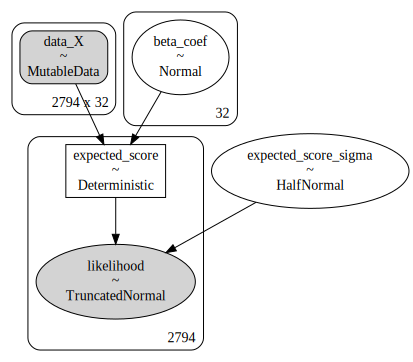

In [ ]:
pm.model_to_graphviz(m1_d1_fit['model'])

In [ ]:
m1_d1_fit_summary = check_pymc_model_fit(model_fit_dict = m1_d1_fit,
                                            var_names = ['beta', 'expected_score_sigma'])

<ipython-input-67-fe9c3bda71ff>:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
<ipython-input-67-fe9c3bda71ff>:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

              Estimate       SE
deviance_waic 20533.90    93.18
p_waic           34.33        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

             Estimate       SE
deviance_loo 20536.79    93.32
p_loo           35.78        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2785   99.7%
 (0.5, 0.7]   (ok)          5    0.2%
   (0.7, 1]   (bad)         4    0.1%
   (1, Inf)   (very bad)    0    0.0%



2024-04-21 17:25:54.014630	Extracting data from model dictionary
2024-04-21 17:25:54.045498	Extracting model object, trace, and name
2024-04-21 17:25:54.046256	Appending dummy predictor to outsample array for posterior predictive inference
2024-04-21 17:25:54.047248	Insample posterior prediction


2024-04-21 17:26:03.817783	Generating insample posterior predictive plot


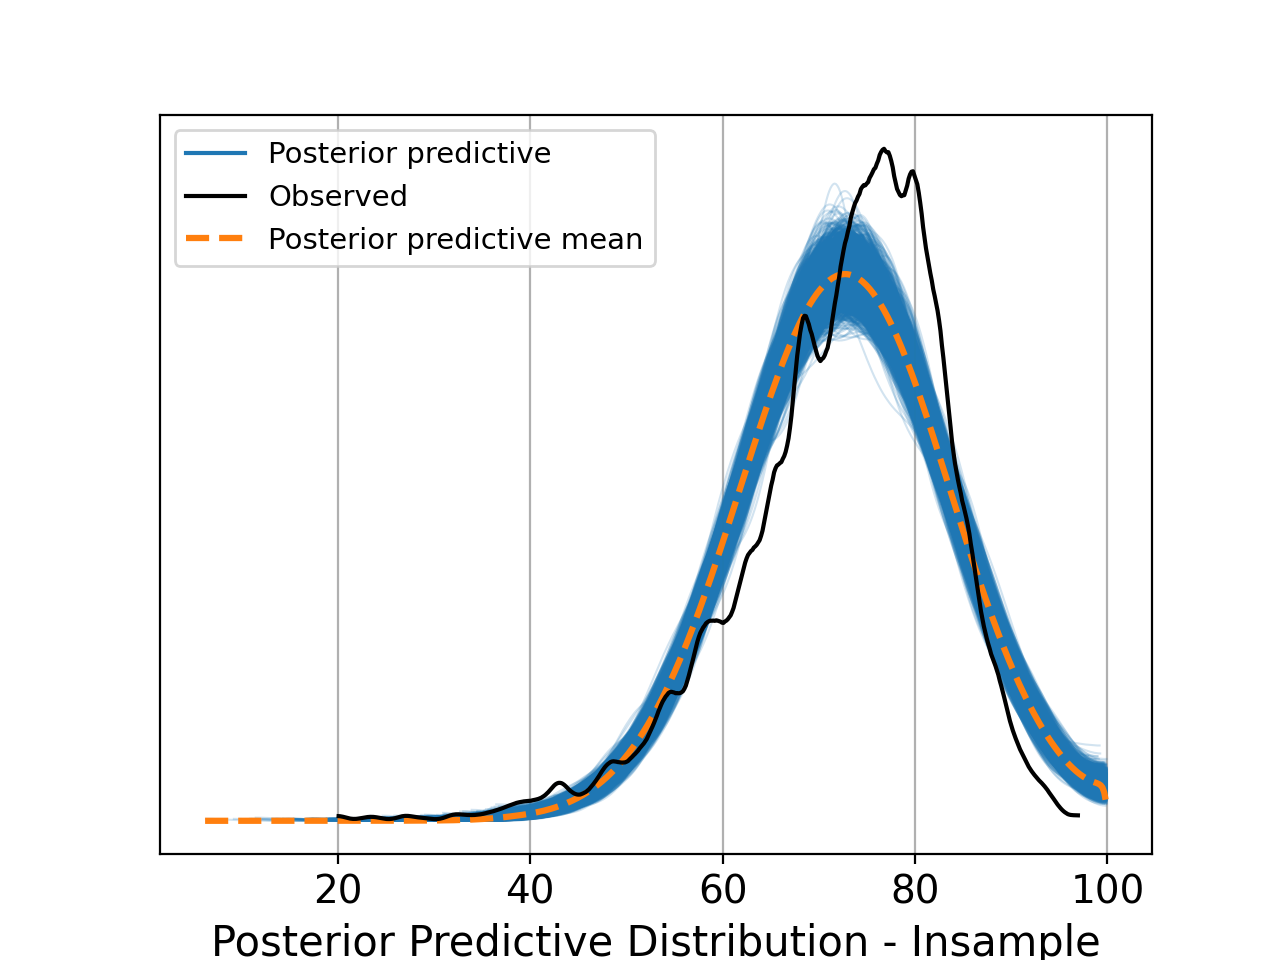

2024-04-21 17:26:43.831662	Extracting predictions
2024-04-21 17:26:43.835386	Outsample posterior predictions


2024-04-21 17:26:48.726580	Arviz R2 Score
2024-04-21 17:26:48.943547	Converting to dataframes
2024-04-21 17:26:48.947192	Sklearn R2 score
2024-04-21 17:26:52.828463	MAE
2024-04-21 17:26:54.120720	MSE
2024-04-21 17:26:55.437091	Combining dataframes
2024-04-21 17:26:55.438845	Preparing evaluation dictionary


In [160]:
m1_d1_eval_summary = evaluate_model(m1_d1_fit)

In [ ]:
m1_d1_eval_summary['error_df']

,metric,average,ste,num_obs,model
0,<function r2_score at 0x7d91d66bc8b0>,0.380513,0.006943,2794,m1_d1_basic_norm_basic_preds
0,<function r2_score at 0x7d91d66bc8b0>,0.437539,0.047282,699,m1_d1_basic_norm_basic_preds
0,<function r2_score at 0x7d91d4b788b0>,-0.654489,0.000706,2794,m1_d1_basic_norm_basic_preds
0,<function r2_score at 0x7d91d4b788b0>,-33.031175,0.071979,699,m1_d1_basic_norm_basic_preds
0,<function mean_absolute_error at 0x7d91d4b78430>,10.647520,0.002440,2794,m1_d1_basic_norm_basic_preds
0,<function mean_absolute_error at 0x7d91d4b78430>,57.104476,0.081939,699,m1_d1_basic_norm_basic_preds
0,<function mean_squared_error at 0x7d91d4b785e0>,181.207993,0.077370,2794,m1_d1_basic_norm_basic_preds
0,<function mean_squared_error at 0x7d91d4b785e0>,3669.338779,7.760978,699,m1_d1_basic_norm_basic_preds


### Basic Predictors with Embedding Point Estimates

In [ ]:
# m1_d2_fit = fit_model_multivariate_normal_basic(dataset_inc_embed_point_estimates, model_name = 'm1_d1_basic_norm_inc_embed_point_estimates')

In [161]:
with open("./data/final_data/model_data_m1_d2_basic_norm_inc_embed_point_estimates.pkl", "rb") as f:
  m1_d2_fit = pickle.load(f)

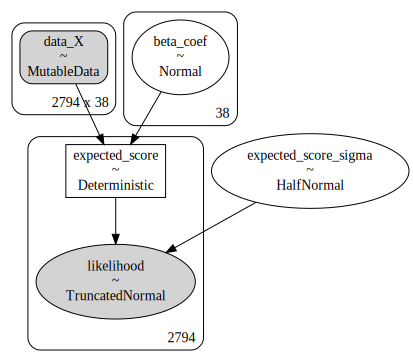

In [ ]:
pm.model_to_graphviz(m1_d2_fit['model'])

In [ ]:
m1_d2_fit['model_name']

'm1_d2_basic_norm_inc_embed_point_estimates'

In [ ]:
m1_d2_fit_summary = check_pymc_model_fit(model_fit_dict = m1_d2_fit,
                                            var_names = ['beta', 'expected_score_sigma'])

<ipython-input-67-fe9c3bda71ff>:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
<ipython-input-67-fe9c3bda71ff>:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

              Estimate       SE
deviance_waic 20480.38    91.71
p_waic           37.94        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

             Estimate       SE
deviance_loo 20482.75    91.83
p_loo           39.12        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2784   99.6%
 (0.5, 0.7]   (ok)          5    0.2%
   (0.7, 1]   (bad)         5    0.2%
   (1, Inf)   (very bad)    0    0.0%



In [ ]:
m1_d2_fit_summary['trace_summary']

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_coef[0],67.494,2.713,61.902,72.489,0.119,0.085,516.0,889.0,1.01
beta_coef[1],0.049,0.222,-0.391,0.484,0.003,0.004,5441.0,2868.0,1.00
beta_coef[2],0.028,0.222,-0.385,0.473,0.004,0.003,3950.0,3112.0,1.00
beta_coef[3],0.109,0.216,-0.308,0.527,0.003,0.003,4269.0,2684.0,1.00
beta_coef[4],-0.847,0.217,-1.258,-0.420,0.003,0.002,4774.0,3195.0,1.00
beta_coef[5],3.136,0.206,2.759,3.560,0.003,0.002,6032.0,3497.0,1.00
beta_coef[6],0.345,0.213,-0.080,0.750,0.003,0.002,5222.0,3125.0,1.00
beta_coef[7],0.109,0.199,-0.272,0.507,0.003,0.003,5358.0,3057.0,1.00
beta_coef[8],0.725,0.215,0.323,1.156,0.003,0.002,5165.0,3138.0,1.00
beta_coef[9],1.152,0.226,0.686,1.569,0.003,0.002,4273.0,3022.0,1.00


2024-04-21 17:26:56.787128	Extracting data from model dictionary
2024-04-21 17:26:56.788268	Extracting model object, trace, and name
2024-04-21 17:26:56.788810	Appending dummy predictor to outsample array for posterior predictive inference
2024-04-21 17:26:56.789728	Insample posterior prediction


2024-04-21 17:27:01.349904	Generating insample posterior predictive plot


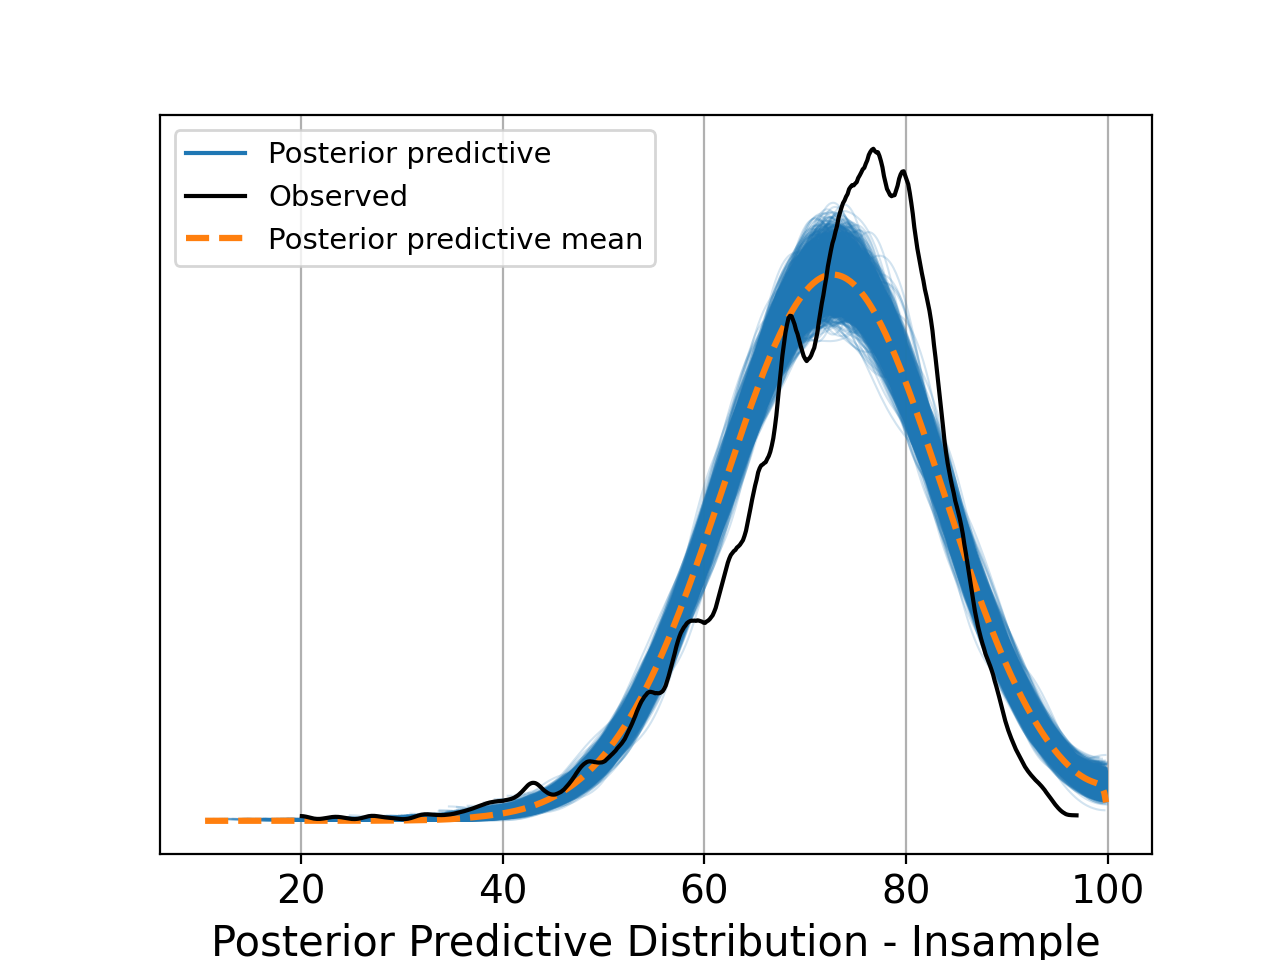

2024-04-21 17:27:39.821639	Extracting predictions
2024-04-21 17:27:39.825992	Outsample posterior predictions


2024-04-21 17:27:44.125253	Arviz R2 Score
2024-04-21 17:27:44.323153	Converting to dataframes
2024-04-21 17:27:44.324435	Sklearn R2 score
2024-04-21 17:27:47.178388	MAE
2024-04-21 17:27:48.722291	MSE
2024-04-21 17:27:50.055977	Combining dataframes
2024-04-21 17:27:50.057790	Preparing evaluation dictionary


In [162]:
m1_d2_eval_summary = evaluate_model(m1_d2_fit)

In [ ]:
m1_d2_eval_summary['error_df']

,metric,average,ste,num_obs,model
0,<function r2_score at 0x7d91d66bc8b0>,0.385731,0.007092,2794,m1_d2_basic_norm_inc_embed_point_estimates
0,<function r2_score at 0x7d91d66bc8b0>,0.455718,0.034585,699,m1_d2_basic_norm_inc_embed_point_estimates
0,<function r2_score at 0x7d91d4b788b0>,-0.619642,0.000685,2794,m1_d2_basic_norm_inc_embed_point_estimates
0,<function r2_score at 0x7d91d4b788b0>,-31.848603,0.065725,699,m1_d2_basic_norm_inc_embed_point_estimates
0,<function mean_absolute_error at 0x7d91d4b78430>,10.541694,0.002409,2794,m1_d2_basic_norm_inc_embed_point_estimates
0,<function mean_absolute_error at 0x7d91d4b78430>,55.290238,0.077850,699,m1_d2_basic_norm_inc_embed_point_estimates
0,<function mean_squared_error at 0x7d91d4b785e0>,177.391378,0.074996,2794,m1_d2_basic_norm_inc_embed_point_estimates
0,<function mean_squared_error at 0x7d91d4b785e0>,3541.830561,7.086621,699,m1_d2_basic_norm_inc_embed_point_estimates


### Basic Predictors with Embedding PCA (JAX NumPyro NUTS Sampler)

In [ ]:
# m1_d3_fit_pyro = fit_model_multivariate_normal_basic(dataset_inc_embed_point_estimates, model_name = 'm1_d3_embedding_pca', use_numpyro = True)

In [163]:
with open("./data/final_data/model_data_m1_d3_basic_norm_embed_pca_numpyro.pkl", "rb") as f:
  m1_d3_fit = pickle.load(f)

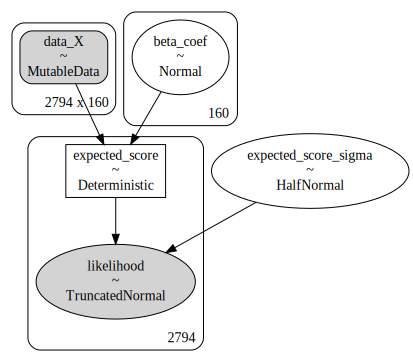

In [164]:
pm.model_to_graphviz(m1_d3_fit['model'])

In [ ]:
m1_d3_fit['model_name']

'model_01_basic_norm::data_03_inc_embed_pca'

In [ ]:
m1_d3_fit['model_name'] = 'm1_d3_basic_pred_inc_embed_pca_numpyro'

In [ ]:
m1_d3_fit['model_name'] = 'm1_d3_basic_norm_basic_preds_inc_embed_pca_numpyro'

In [ ]:
m1_d3_fit_summary = check_pymc_model_fit(model_fit_dict = m1_d3_fit,
                                            var_names = ['beta', 'expected_score_sigma'])

<ipython-input-67-fe9c3bda71ff>:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
<ipython-input-67-fe9c3bda71ff>:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


Computed from 8000 posterior samples and 2794 observations log-likelihood matrix.

              Estimate       SE
deviance_waic 18611553.59  218678.90
p_waic        9294524.06        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.


Computed from 8000 posterior samples and 2794 observations log-likelihood matrix.

             Estimate       SE
deviance_loo 720426.83  4379.58
p_loo        348960.68        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad) 2793  100.0%



2024-04-20 20:12:29.601992	Extracting data from model dictionary
2024-04-20 20:12:29.602927	Extracting model object, trace, and name
2024-04-20 20:12:29.603427	Appending dummy predictor to outsample array for posterior predictive inference
2024-04-20 20:12:29.604341	Insample posterior prediction


2024-04-20 20:12:47.748726	Generating insample posterior predictive plot


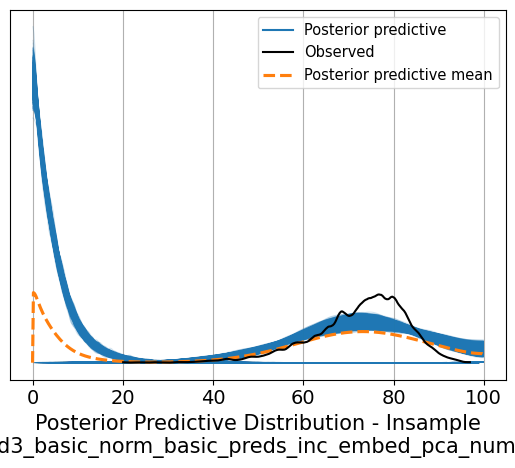

2024-04-20 20:13:55.337777	Extracting predictions
2024-04-20 20:13:55.342131	Outsample posterior predictions


2024-04-20 20:14:07.281777	Arviz R2 Score
2024-04-20 20:14:07.562997	Converting to dataframes
2024-04-20 20:14:07.564212	Sklearn R2 score
2024-04-20 20:14:12.023059	MAE
2024-04-20 20:14:14.841845	MSE
2024-04-20 20:14:18.759070	Combining dataframes
2024-04-20 20:14:18.763432	Preparing evaluation dictionary


In [ ]:
m1_d3_eval_summary = evaluate_model(m1_d3_fit)

In [ ]:
m1_d3_eval_summary['error_df']

,metric,average,ste,num_obs,model
0,<function r2_score at 0x7adf5953bb50>,0.366965,0.117713,2794,m1_d3_basic_norm_basic_preds_inc_embed_pca_num...
0,<function r2_score at 0x7adf5953bb50>,0.488676,0.011267,699,m1_d3_basic_norm_basic_preds_inc_embed_pca_num...
0,<function r2_score at 0x7adf57a1c700>,-11.432558,0.197391,2794,m1_d3_basic_norm_basic_preds_inc_embed_pca_num...
0,<function r2_score at 0x7adf57a1c700>,-29.162634,0.034276,699,m1_d3_basic_norm_basic_preds_inc_embed_pca_num...
0,<function mean_absolute_error at 0x7adf57a1c280>,26.223294,0.267693,2794,m1_d3_basic_norm_basic_preds_inc_embed_pca_num...
0,<function mean_absolute_error at 0x7adf57a1c280>,51.539700,0.040031,699,m1_d3_basic_norm_basic_preds_inc_embed_pca_num...
0,<function mean_squared_error at 0x7adf57a1c430>,1361.676882,21.619211,2794,m1_d3_basic_norm_basic_preds_inc_embed_pca_num...
0,<function mean_squared_error at 0x7adf57a1c430>,3252.221641,3.695773,699,m1_d3_basic_norm_basic_preds_inc_embed_pca_num...


### Basic Predictors with Embedding PCA (PyMC Sampler)

In [ ]:
# m1_d3a_fit = fit_model_multivariate_normal_basic(dataset_inc_embed_point_estimates, model_name = 'm1_d3_embedding_pca_pymc_sampler', use_numpyro = True)

In [165]:
with open("./data/final_data/model_data_m1_d3_basic_norm_embed_pca.pkl", "rb") as f:
  m1_d3a_fit = pickle.load(f)

In [166]:
m1_d3a_fit['model_name'] = 'm1_d3_basic_norm_embed_pca_pymc_sampler'

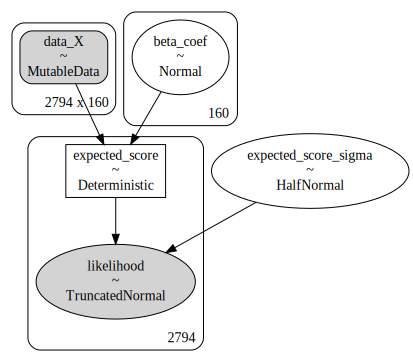

In [ ]:
pm.model_to_graphviz(m1_d3a_fit['model'])

In [ ]:
m1_d3a_fit_summary = check_pymc_model_fit(model_fit_dict = m1_d3a_fit,
                                            var_names = ['beta', 'expected_score_sigma'])

<ipython-input-67-fe9c3bda71ff>:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
<ipython-input-67-fe9c3bda71ff>:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

              Estimate       SE
deviance_waic 20361.37    93.93
p_waic           80.77        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

             Estimate       SE
deviance_loo 20364.55    94.03
p_loo           82.36        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2787   99.7%
 (0.5, 0.7]   (ok)          6    0.2%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%



2024-04-21 17:27:54.644630	Extracting data from model dictionary
2024-04-21 17:27:54.644736	Extracting model object, trace, and name
2024-04-21 17:27:54.644764	Appending dummy predictor to outsample array for posterior predictive inference
2024-04-21 17:27:54.647210	Insample posterior prediction


2024-04-21 17:27:59.958529	Generating insample posterior predictive plot


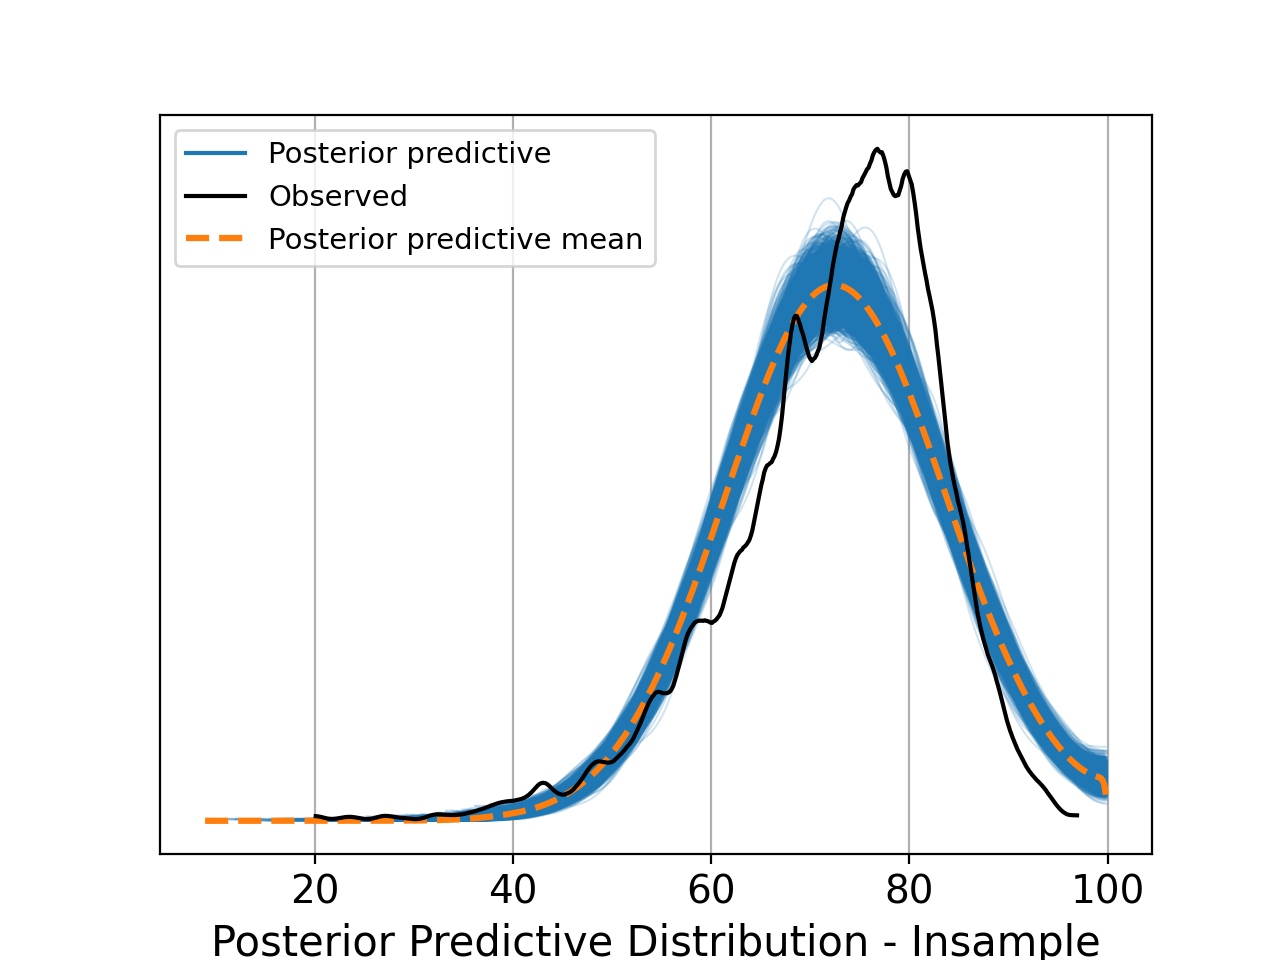

2024-04-21 17:28:30.841834	Extracting predictions
2024-04-21 17:28:30.845394	Outsample posterior predictions


2024-04-21 17:28:35.326264	Arviz R2 Score
2024-04-21 17:28:35.447185	Converting to dataframes
2024-04-21 17:28:35.448329	Sklearn R2 score
2024-04-21 17:28:39.437996	MAE
2024-04-21 17:28:41.513618	MSE
2024-04-21 17:28:43.053066	Combining dataframes
2024-04-21 17:28:43.054901	Preparing evaluation dictionary


In [167]:
m1_d3a_eval_summary = evaluate_model(m1_d3a_fit)

In [ ]:
m1_d3a_eval_summary['error_df']

,metric,average,ste,num_obs,model
0,<function r2_score at 0x7d91d66bc8b0>,0.407441,0.007286,2794,m1_d3_basic_norm_embed_pca_pymc_sampler
0,<function r2_score at 0x7d91d66bc8b0>,0.489275,0.011099,699,m1_d3_basic_norm_embed_pca_pymc_sampler
0,<function r2_score at 0x7d91d4b788b0>,-0.530477,0.000666,2794,m1_d3_basic_norm_embed_pca_pymc_sampler
0,<function r2_score at 0x7d91d4b788b0>,-29.629363,0.046050,699,m1_d3_basic_norm_embed_pca_pymc_sampler
0,<function mean_absolute_error at 0x7d91d4b78430>,10.225444,0.002406,2794,m1_d3_basic_norm_embed_pca_pymc_sampler
0,<function mean_absolute_error at 0x7d91d4b78430>,52.036870,0.054448,699,m1_d3_basic_norm_embed_pca_pymc_sampler
0,<function mean_squared_error at 0x7d91d4b785e0>,167.625658,0.072926,2794,m1_d3_basic_norm_embed_pca_pymc_sampler
0,<function mean_squared_error at 0x7d91d4b785e0>,3302.545654,4.965252,699,m1_d3_basic_norm_embed_pca_pymc_sampler


## Unpooled Poisson Multivariate Model

### Functions

In [168]:
def fit_model_multivariate_poisson_basic(data_dict,
                                        model_name,
                                        num_samples = 2000,
                                        num_warmups = 2000,
                                        num_chains = 2,
                                        use_numpyro = False):
  # Extract the training predictors and responses
  data_X = data_dict['train_X']
  data_y = data_dict['train_y']

  # Add an intercept term to the predictors
  data_X = np.hstack([np.ones((data_X.shape[0], 1)), data_X])

  # Extract predictor_names and make a coordinates dictionary
  predictor_names = ['intercept'] + data_dict['predictor_names']

  # Create a PyMC model
  with pm.Model() as my_model:
    # Priors on regression coefficients independent of the source of the predictor
    data_X = pm.MutableData('data_X', data_X)
    beta_coef = pm.Normal('beta_coef', mu = 0, sigma = 10, shape = data_X.shape[1])

    # Under Poisson model, likelihood has an expected rate parameter
    expected_score_raw = pm.math.dot(data_X, beta_coef)
    # expected_score_exp_link = pm.math.exp(expected_score_raw)
    expected_score_exp_link = np.exp(expected_score_raw)

    # No longer assuming likelihood is a continuous score. Assume discrete.
    # Ideally, model should learn coefficients that will constraint
    # expected_score_exp_link such that posterior predictions will be [0, 100]
    likelihood = pm.Poisson('likelihood',
                            mu = expected_score_exp_link,
                            shape = data_X.shape[0],
                            observed = data_y)

    # This doesn't work because
    # poisson_dist = pm.Poisson.dist(mu = expected_score_exp_link)
    # likelihood = pm.Truncated('likelihood', poisson_dist, observed = data_y,
    #                           shape = data_y.shape[0], upper = 100, lower = 0)

  # Plot the model
  pm.model_to_graphviz(my_model)
  plt.show()

  # Fit the model
  t_fit_start = datetime.now()
  if use_numpyro:
    with my_model:
      my_model_trace = pm.sampling_jax.sample_numpyro_nuts(
          num_samples, target_accept = 0.95, tune = num_warmups, random_seed = EXPERIMENT_SEED
      )
  else:
    with my_model:
      my_model_trace = pm.sample(num_samples, tune = num_warmups, cores = num_chains,
                              target_accept = 0.95,
                              random_seed = EXPERIMENT_SEED)
  t_fit_end = datetime.now()
  t_fit = (t_fit_end - t_fit_start).total_seconds() / 60
  print(f"Model fit in {t_fit} min")

  # Compute log likelihood as well
  with my_model:
    pm.compute_log_likelihood(idata = my_model_trace)

  # Save the model files
  save_file_path = f'./data/model_data_{model_name}.pkl'
  model_dict = {
      'data': data_dict,
      'model_name': model_name,
      'model': my_model,
      'trace': my_model_trace,
      't_fit': t_fit
  }

  with open(save_file_path, 'wb') as f:
    cloudpickle.dump(model_dict, f)

  return model_dict

### Basic Predictors

In [ ]:
# m2_d1_fit = fit_model_multivariate_poisson_basic(dataset_basic_predictors, model_name = 'm2_d1_basic_poisson_no_deterministic')

In [169]:
with open("./data/model_data_m2_d1_basic_poisson_basic_preds.pkl", "rb") as f:
  m2_d1_fit = pickle.load(f)

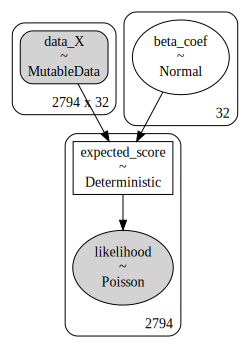

In [ ]:
pm.model_to_graphviz(m2_d1_fit['model'])

In [ ]:
m2_d1_fit['model_name']

'm2_d1_basic_poisson_basic_preds'

In [ ]:
m2_d1_fit_summary = check_pymc_model_fit(model_fit_dict = m2_d1_fit, var_names = ['beta'])

<ipython-input-67-fe9c3bda71ff>:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
<ipython-input-67-fe9c3bda71ff>:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

              Estimate       SE
deviance_waic 20865.43   142.59
p_waic           42.11        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

             Estimate       SE
deviance_loo 20870.62   142.75
p_loo           44.70        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2783   99.6%
 (0.5, 0.7]   (ok)          5    0.2%
   (0.7, 1]   (bad)         5    0.2%
   (1, Inf)   (very bad)    1    0.0%



2024-04-21 17:28:44.262618	Extracting data from model dictionary
2024-04-21 17:28:44.263680	Extracting model object, trace, and name
2024-04-21 17:28:44.264278	Appending dummy predictor to outsample array for posterior predictive inference
2024-04-21 17:28:44.265005	Insample posterior prediction


2024-04-21 17:28:45.868631	Generating insample posterior predictive plot


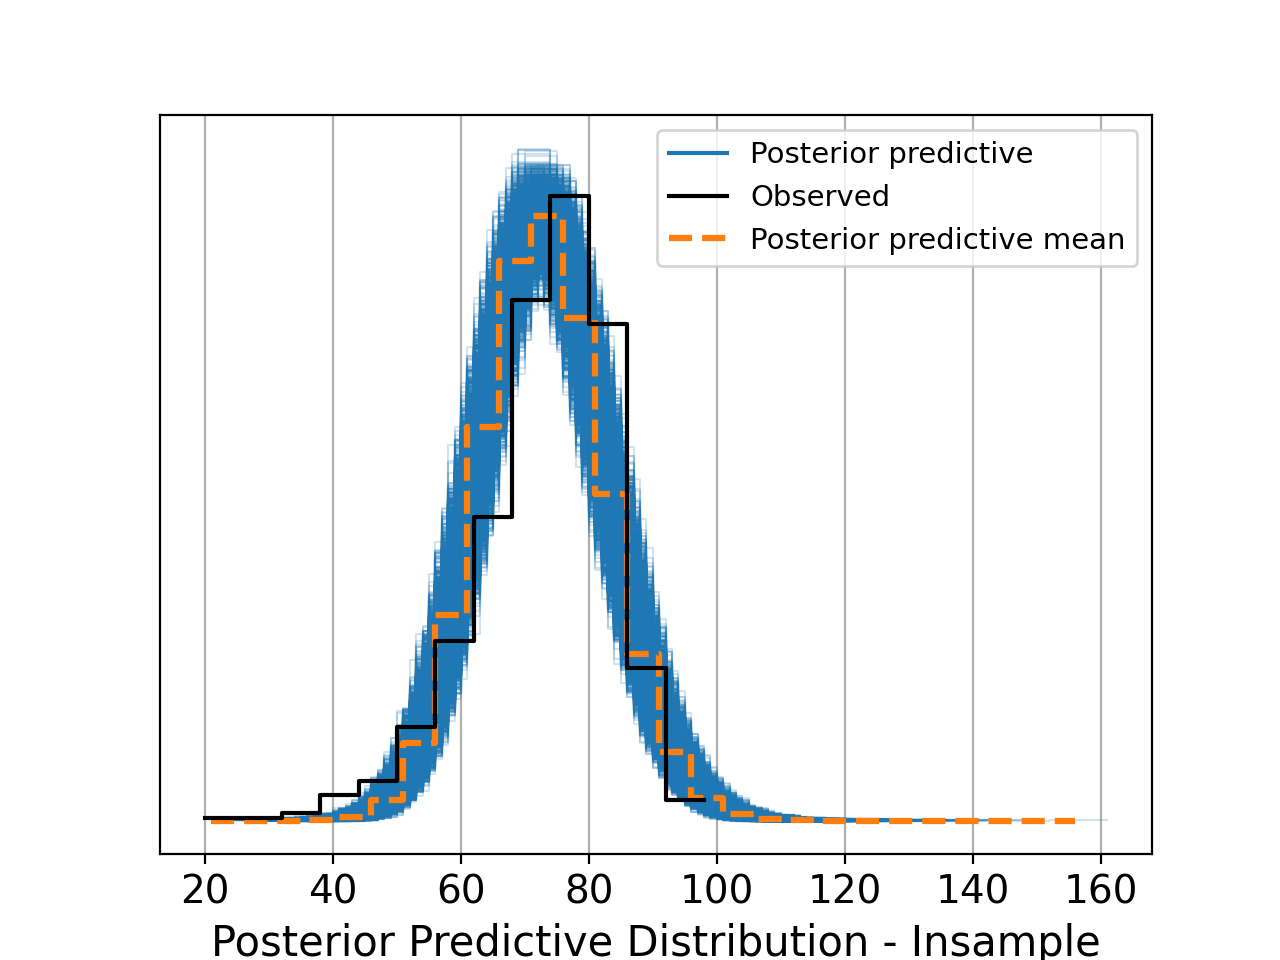

2024-04-21 17:28:53.618331	Extracting predictions
2024-04-21 17:28:53.628120	Performing manual posterior predictive inference with likelihood poisson
2024-04-21 17:28:53.828619	Arviz R2 Score
2024-04-21 17:28:53.915333	Converting to dataframes
2024-04-21 17:28:53.917218	Sklearn R2 score
2024-04-21 17:28:55.184752	MAE
2024-04-21 17:28:55.911971	MSE
2024-04-21 17:28:56.451449	Combining dataframes
2024-04-21 17:28:56.453145	Preparing evaluation dictionary


In [170]:
m2_d1_eval_summary = evaluate_model(model_fit_dict = m2_d1_fit,
                                    generate_manual_predictions = True,
                                    model_likelihood_name = 'poisson')

In [ ]:
m2_d1_eval_summary['error_df']

,metric,average,ste,num_obs,model
0,<function r2_score at 0x7d91d66bc8b0>,0.363624,0.006925,2794,m2_d1_basic_poisson_basic_preds
0,<function r2_score at 0x7d91d66bc8b0>,0.214248,0.000000,699,m2_d1_basic_poisson_basic_preds
0,<function r2_score at 0x7d91d4b788b0>,-0.488511,0.000521,2794,m2_d1_basic_poisson_basic_preds
0,<function r2_score at 0x7d91d4b788b0>,-1.063855,0.000000,699,m2_d1_basic_poisson_basic_preds
0,<function mean_absolute_error at 0x7d91d4b78430>,10.079909,0.001921,2794,m2_d1_basic_poisson_basic_preds
0,<function mean_absolute_error at 0x7d91d4b78430>,12.133047,0.000000,699,m2_d1_basic_poisson_basic_preds
0,<function mean_squared_error at 0x7d91d4b785e0>,163.029270,0.057064,2794,m2_d1_basic_poisson_basic_preds
0,<function mean_squared_error at 0x7d91d4b785e0>,222.530758,0.000000,699,m2_d1_basic_poisson_basic_preds


### Basic Predictors with Embedding Point Estimates

In [ ]:
# m2_d2_fit = fit_model_multivariate_poisson_basic(dataset_inc_embed_point_estimates, model_name = 'm2_d2_basic_poisson_inc_embed_point_estimates')

In [171]:
with open("./data/final_data/model_data_m2_d2_basic_poisson_inc_embed_point_estimates.pkl", "rb") as f:
  m2_d2_fit = pickle.load(f)

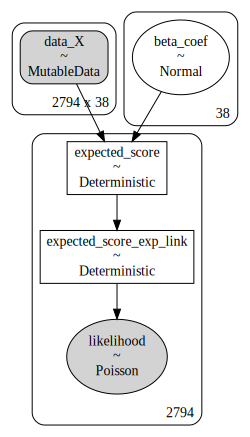

In [ ]:
pm.model_to_graphviz(m2_d2_fit['model'])

In [ ]:
m2_d2_fit['model_name']

'm2_d2_basic_poisson_inc_embed_point_estimates'

In [ ]:
m2_d2_fit_summary = check_pymc_model_fit(model_fit_dict = m2_d2_fit, var_names = ['beta'])

<ipython-input-67-fe9c3bda71ff>:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
<ipython-input-67-fe9c3bda71ff>:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

              Estimate       SE
deviance_waic 20775.62   136.38
p_waic           31.03        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

             Estimate       SE
deviance_loo 20779.97   136.68
p_loo           33.21        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2752   98.5%
 (0.5, 0.7]   (ok)         23    0.8%
   (0.7, 1]   (bad)        17    0.6%
   (1, Inf)   (very bad)    2    0.1%



2024-04-21 17:28:58.405140	Extracting data from model dictionary
2024-04-21 17:28:58.405227	Extracting model object, trace, and name
2024-04-21 17:28:58.405266	Appending dummy predictor to outsample array for posterior predictive inference
2024-04-21 17:28:58.405979	Insample posterior prediction


2024-04-21 17:29:00.076503	Generating insample posterior predictive plot


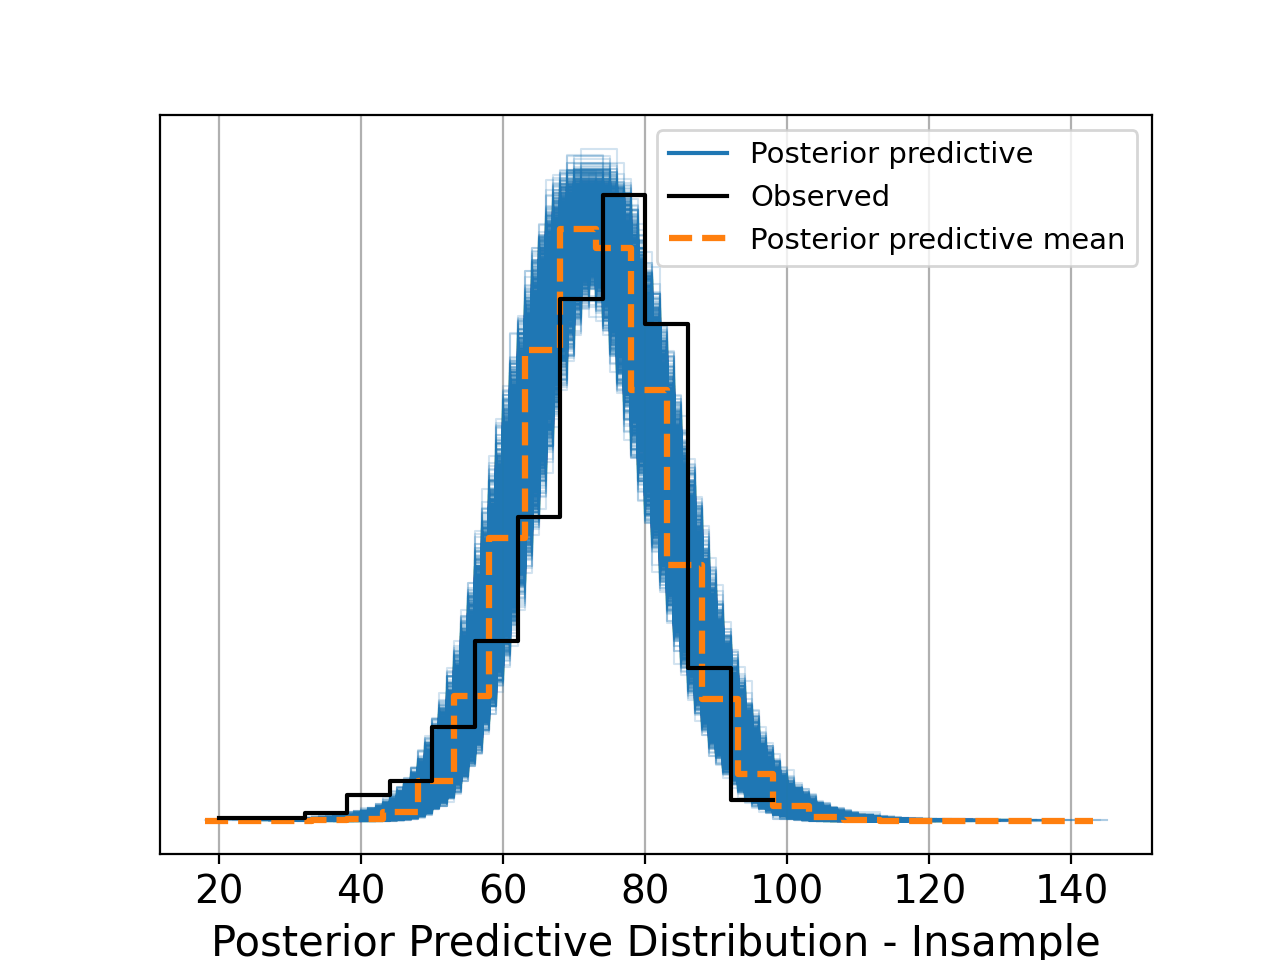

2024-04-21 17:29:07.849178	Extracting predictions
2024-04-21 17:29:07.852361	Performing manual posterior predictive inference with likelihood poisson
2024-04-21 17:29:08.123906	Arviz R2 Score
2024-04-21 17:29:08.212478	Converting to dataframes
2024-04-21 17:29:08.215661	Sklearn R2 score
2024-04-21 17:29:09.377123	MAE
2024-04-21 17:29:09.910501	MSE
2024-04-21 17:29:10.453186	Combining dataframes
2024-04-21 17:29:10.454962	Preparing evaluation dictionary


In [172]:
m2_d2_eval_summary = evaluate_model(model_fit_dict = m2_d2_fit,
                                    generate_manual_predictions = True,
                                    model_likelihood_name = 'poisson')

In [ ]:
m2_d2_eval_summary['error_df']

,metric,average,ste,num_obs,model
0,<function r2_score at 0x7d91d66bc8b0>,0.371904,0.006437,2794,m2_d2_basic_poisson_inc_embed_point_estimates
0,<function r2_score at 0x7d91d66bc8b0>,0.239974,0.000000,699,m2_d2_basic_poisson_inc_embed_point_estimates
0,<function r2_score at 0x7d91d4b788b0>,-0.470595,0.000509,2794,m2_d2_basic_poisson_inc_embed_point_estimates
0,<function r2_score at 0x7d91d4b788b0>,-1.037690,0.000000,699,m2_d2_basic_poisson_inc_embed_point_estimates
0,<function mean_absolute_error at 0x7d91d4b78430>,10.038468,0.001902,2794,m2_d2_basic_poisson_inc_embed_point_estimates
0,<function mean_absolute_error at 0x7d91d4b78430>,12.124464,0.000000,699,m2_d2_basic_poisson_inc_embed_point_estimates
0,<function mean_squared_error at 0x7d91d4b785e0>,161.066990,0.055725,2794,m2_d2_basic_poisson_inc_embed_point_estimates
0,<function mean_squared_error at 0x7d91d4b785e0>,219.709585,0.000000,699,m2_d2_basic_poisson_inc_embed_point_estimates


### Basic Predictors with Embedding PCA

In [ ]:
# m2_d3_fit = fit_model_multivariate_poisson_basic(dataset_inc_embed_pca, model_name = 'm2_d2_basic_poisson_inc_embed_point_estimates')

In [173]:
with open("./data/final_data/model_data_m2_d3_poisson_basic_preds_inc_embed_pca.pkl", "rb") as f:
  m2_d3_fit = pickle.load(f)

In [ ]:
m2_d3_fit['model_name']

'm2_d3_poisson_basic_preds_inc_embed_pca'

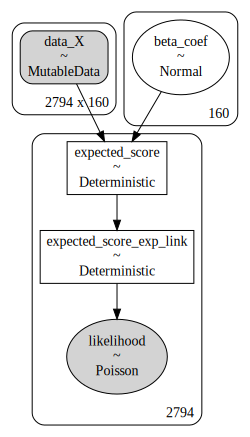

In [ ]:
pm.model_to_graphviz(m2_d3_fit['model'])

In [ ]:
m2_d3_fit_summary = check_pymc_model_fit(model_fit_dict = m2_d3_fit, var_names = ['beta'])

<ipython-input-67-fe9c3bda71ff>:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
<ipython-input-67-fe9c3bda71ff>:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

              Estimate       SE
deviance_waic 20653.88   134.92
p_waic           91.43        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

             Estimate       SE
deviance_loo 20656.46   134.91
p_loo           92.72        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2784   99.6%
 (0.5, 0.7]   (ok)          6    0.2%
   (0.7, 1]   (bad)         4    0.1%
   (1, Inf)   (very bad)    0    0.0%



2024-04-21 17:29:12.229656	Extracting data from model dictionary
2024-04-21 17:29:12.230639	Extracting model object, trace, and name
2024-04-21 17:29:12.231140	Appending dummy predictor to outsample array for posterior predictive inference
2024-04-21 17:29:12.232060	Insample posterior prediction


2024-04-21 17:29:13.765341	Generating insample posterior predictive plot


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


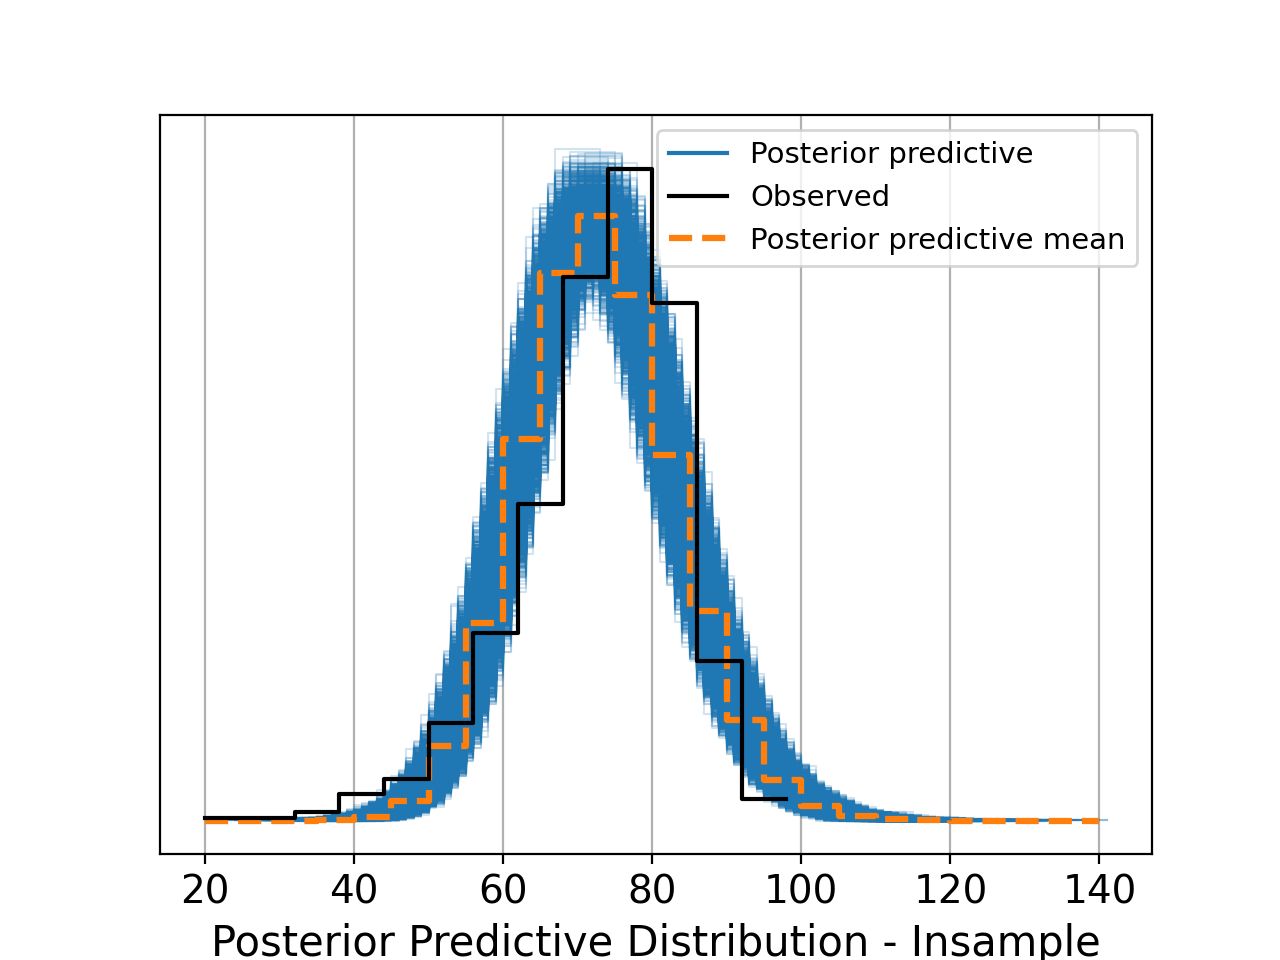

2024-04-21 17:29:23.954131	Extracting predictions
2024-04-21 17:29:23.958040	Performing manual posterior predictive inference with likelihood poisson
2024-04-21 17:29:24.152210	Arviz R2 Score
2024-04-21 17:29:24.224428	Converting to dataframes
2024-04-21 17:29:24.226320	Sklearn R2 score
2024-04-21 17:29:25.040221	MAE
2024-04-21 17:29:25.587206	MSE
2024-04-21 17:29:26.123076	Combining dataframes
2024-04-21 17:29:26.124772	Preparing evaluation dictionary


In [174]:
m2_d3_eval_summary = evaluate_model(model_fit_dict = m2_d3_fit,
                                    generate_manual_predictions = True,
                                    model_likelihood_name = 'poisson')

In [ ]:
m2_d3_eval_summary['error_df']

,metric,average,ste,num_obs,model
0,<function r2_score at 0x7d91d66bc8b0>,0.399079,0.007394,2794,m2_d3_poisson_basic_preds_inc_embed_pca
0,<function r2_score at 0x7d91d66bc8b0>,0.294066,0.000000,699,m2_d3_poisson_basic_preds_inc_embed_pca
0,<function r2_score at 0x7d91d4b788b0>,-0.425743,0.000519,2794,m2_d3_poisson_basic_preds_inc_embed_pca
0,<function r2_score at 0x7d91d4b788b0>,-1.013794,0.000000,699,m2_d3_poisson_basic_preds_inc_embed_pca
0,<function mean_absolute_error at 0x7d91d4b78430>,9.865544,0.001990,2794,m2_d3_poisson_basic_preds_inc_embed_pca
0,<function mean_absolute_error at 0x7d91d4b78430>,12.200286,0.000000,699,m2_d3_poisson_basic_preds_inc_embed_pca
0,<function mean_squared_error at 0x7d91d4b785e0>,156.154589,0.056834,2794,m2_d3_poisson_basic_preds_inc_embed_pca
0,<function mean_squared_error at 0x7d91d4b785e0>,217.133047,0.000000,699,m2_d3_poisson_basic_preds_inc_embed_pca


## Unpooled Negative Binomial Multivariate Model

Built this model on Aaron's suggestion even though it used to model the number of successes until the `n`th failure under a binomial process.

Poisson distribution assumes mean and variance of data are the same. If variance is much larger than mean (data is more diffuse), then negative binomial likelihood is worth trying.

In [175]:
def fit_model_multivariate_neg_binom_basic(data_dict,
                                        model_name,
                                        num_samples = 2000,
                                        num_warmups = 2000,
                                        num_chains = 2,
                                        use_numpyro = False):
  # Extract the training predictors and responses
  data_X = data_dict['train_X']
  data_y = data_dict['train_y']

  # Add an intercept term to the predictors
  data_X = np.hstack([np.ones((data_X.shape[0], 1)), data_X])

  # Extract predictor_names and make a coordinates dictionary
  predictor_names = ['intercept'] + data_dict['predictor_names']

  # Create a PyMC model
  with pm.Model() as my_model:
    # Priors on regression coefficients independent of the source of the predictor
    data_X = pm.MutableData('data_X', data_X)
    beta_coef = pm.Normal('beta_coef', mu = 0, sigma = 10, shape = data_X.shape[1])
    mu = pm.math.dot(data_X, beta_coef)

    # Using this link as a source of exponential as link function
    # https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-negative-binomial-regression.html
    mu_exp = np.exp(mu)
    alpha = pm.Gamma('phi', alpha = 2, beta = 2)

    # Negative binomial log likelihood bounded between 0 and 100
    # neg_binom_dist = pm.NegativeBinomial.dist(mu = mu, alpha = alpha)
    # likelihood = pm.Truncated('likelihood', neg_binom_dist, observed = data_y,
    #                           shape = data_y.shape[0], upper = 100, lower = 0)
    likelihood = pm.NegativeBinomial('likelihood',
                                     mu = mu_exp,
                                     alpha = alpha,
                                     shape = data_X.shape[0],
                                     observed = data_y)

  # Plot the model
  pm.model_to_graphviz(my_model)
  plt.show()

  # Fit the model
  t_fit_start = datetime.now()
  if use_numpyro:
    with my_model:
      my_model_trace = pm.sampling_jax.sample_numpyro_nuts(
          num_samples, target_accept = 0.95, tune = num_warmups, random_seed = EXPERIMENT_SEED
      )
  else:
    with my_model:
      my_model_trace = pm.sample(num_samples, tune = num_warmups, cores = num_chains,
                              target_accept = 0.95,
                              random_seed = EXPERIMENT_SEED)
  t_fit_end = datetime.now()
  t_fit = (t_fit_end - t_fit_start).total_seconds() / 60
  print(f"Model fit in {t_fit} min")

  # Compute log likelihood as well
  with my_model:
    pm.compute_log_likelihood(idata = my_model_trace)

  # Save the model files
  save_file_path = f'./data/model_data_{model_name}.pkl'
  model_dict = {
      'data': data_dict,
      'model_name': model_name,
      'model': my_model,
      'trace': my_model_trace,
      't_fit': t_fit
  }

  with open(save_file_path, 'wb') as f:
    cloudpickle.dump(model_dict, f)

  return model_dict

### Basic Predictors

In [ ]:
# m3_d1_fit = fit_model_multivariate_neg_binom_basic(dataset_basic_predictors, model_name = 'm3_d1_basic_neg_binom_basic_preds')

In [176]:
with open("./data/final_data/model_data_m3_d1_basic_neg_binom_basic_preds.pkl", "rb") as f:
  m3_d1_fit = pickle.load(f)

In [ ]:
m3_d1_fit['model_name']

'm3_d1_basic_neg_binom_basic_preds_correct_shape'

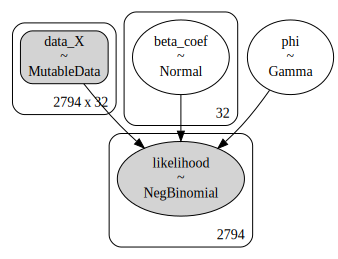

In [ ]:
pm.model_to_graphviz(m3_d1_fit['model'])

In [ ]:
m3_d1_fit_summary = check_pymc_model_fit(model_fit_dict = m3_d1_fit, var_names = ['beta', 'phi'])

<ipython-input-67-fe9c3bda71ff>:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
<ipython-input-67-fe9c3bda71ff>:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

              Estimate       SE
deviance_waic 20923.21    82.50
p_waic           25.52        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

             Estimate       SE
deviance_loo 20927.19    82.66
p_loo           27.51        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2784   99.6%
 (0.5, 0.7]   (ok)          5    0.2%
   (0.7, 1]   (bad)         4    0.1%
   (1, Inf)   (very bad)    1    0.0%



In [ ]:
m3_d1_fit_summary['trace_summary']

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_coef[0],4.379,2.441,-0.378,9.075,0.472,0.338,27.0,77.0,1.07
beta_coef[1],0.002,0.004,-0.004,0.010,0.000,0.000,584.0,1031.0,1.00
beta_coef[2],0.000,0.004,-0.007,0.008,0.000,0.000,343.0,672.0,1.00
beta_coef[3],0.001,0.004,-0.005,0.008,0.000,0.000,520.0,1132.0,1.00
beta_coef[4],-0.009,0.003,-0.015,-0.002,0.000,0.000,927.0,1643.0,1.00
beta_coef[5],0.047,0.004,0.039,0.053,0.000,0.000,616.0,1079.0,1.00
beta_coef[6],0.005,0.003,-0.002,0.011,0.000,0.000,578.0,1292.0,1.01
beta_coef[7],0.001,0.003,-0.006,0.007,0.000,0.000,636.0,1397.0,1.01
beta_coef[8],0.011,0.004,0.004,0.018,0.000,0.000,601.0,1173.0,1.00
beta_coef[9],0.014,0.004,0.007,0.021,0.000,0.000,611.0,1370.0,1.00


2024-04-21 17:29:26.775489	Extracting data from model dictionary
2024-04-21 17:29:26.777051	Extracting model object, trace, and name
2024-04-21 17:29:26.777653	Appending dummy predictor to outsample array for posterior predictive inference
2024-04-21 17:29:26.778596	Insample posterior prediction


2024-04-21 17:29:30.136133	Generating insample posterior predictive plot


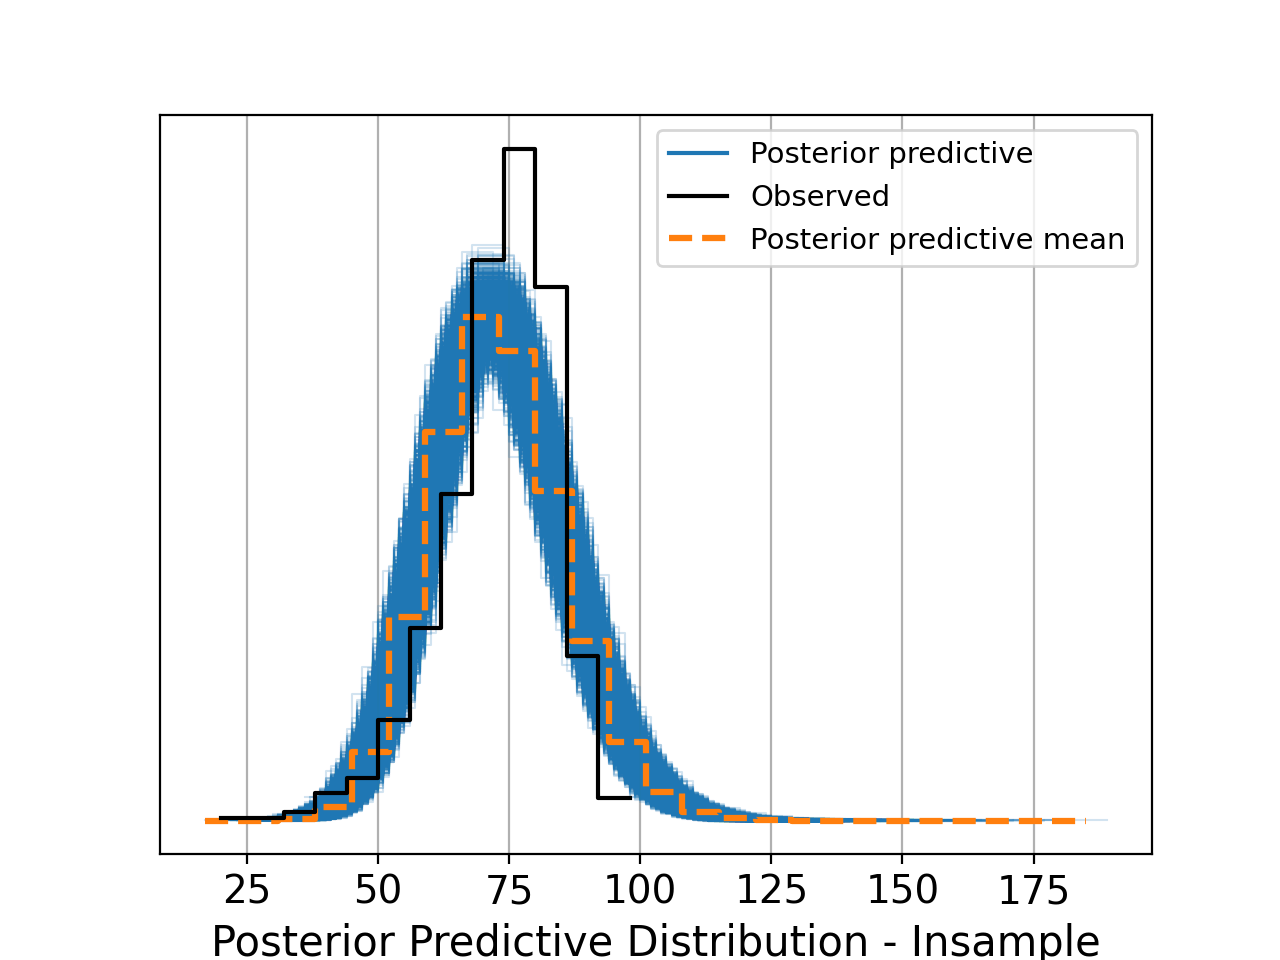

2024-04-21 17:29:38.794072	Extracting predictions
2024-04-21 17:29:38.797294	Performing manual posterior predictive inference with likelihood neg_binomial
2024-04-21 17:29:39.153428	Arviz R2 Score
2024-04-21 17:29:39.222182	Converting to dataframes
2024-04-21 17:29:39.223219	Sklearn R2 score
2024-04-21 17:29:39.999215	MAE
2024-04-21 17:29:40.531892	MSE
2024-04-21 17:29:41.058203	Combining dataframes
2024-04-21 17:29:41.059898	Preparing evaluation dictionary


In [177]:
m3_d1_eval_summary = evaluate_model(model_fit_dict = m3_d1_fit,
                                    generate_manual_predictions = True,
                                    model_likelihood_name = 'neg_binomial')

In [ ]:
m3_d1_eval_summary['error_df']

,metric,average,ste,num_obs,model
0,<function r2_score at 0x7d91d66bc8b0>,0.408056,0.006523,2794,m3_d1_basic_neg_binom_basic_preds_correct_shape
0,<function r2_score at 0x7d91d66bc8b0>,0.224029,0.000000,699,m3_d1_basic_neg_binom_basic_preds_correct_shape
0,<function r2_score at 0x7d91d4b788b0>,-1.050481,0.000915,2794,m3_d1_basic_neg_binom_basic_preds_correct_shape
0,<function r2_score at 0x7d91d4b788b0>,0.097590,0.000000,699,m3_d1_basic_neg_binom_basic_preds_correct_shape
0,<function mean_absolute_error at 0x7d91d4b78430>,11.894888,0.002804,2794,m3_d1_basic_neg_binom_basic_preds_correct_shape
0,<function mean_absolute_error at 0x7d91d4b78430>,7.263233,0.000000,699,m3_d1_basic_neg_binom_basic_preds_correct_shape
0,<function mean_squared_error at 0x7d91d4b785e0>,224.579086,0.100246,2794,m3_d1_basic_neg_binom_basic_preds_correct_shape
0,<function mean_squared_error at 0x7d91d4b785e0>,97.300429,0.000000,699,m3_d1_basic_neg_binom_basic_preds_correct_shape


### Basic Predictors with Embedding Point Estimates

In [ ]:
# m3_d2_fit = fit_model_multivariate_neg_binom_basic(dataset_inc_embed_point_estimates, model_name = 'm3_d1_basic_neg_binom_basic_preds')

In [178]:
with open("./data/final_data/model_data_m3_d2_basic_neg_binom_inc_embed_point_estimates.pkl", "rb") as f:
  m3_d2_fit = pickle.load(f)

In [ ]:
m3_d2_fit['model_name']

'm3_d2_basic_neg_binom_inc_embed'

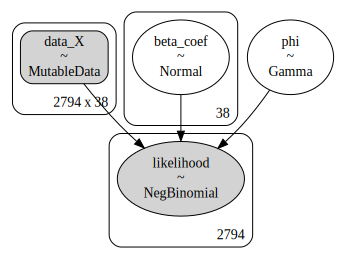

In [ ]:
pm.model_to_graphviz(m3_d2_fit['model'])

In [ ]:
m3_d2_fit_summary = check_pymc_model_fit(model_fit_dict = m3_d2_fit, var_names = ['beta', 'phi'])

<ipython-input-67-fe9c3bda71ff>:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
<ipython-input-67-fe9c3bda71ff>:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

              Estimate       SE
deviance_waic 20881.52    80.68
p_waic           28.40        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

             Estimate       SE
deviance_loo 20883.46    80.71
p_loo           29.38        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2787   99.7%
 (0.5, 0.7]   (ok)          4    0.1%
   (0.7, 1]   (bad)         2    0.1%
   (1, Inf)   (very bad)    1    0.0%



2024-04-21 17:29:41.686428	Extracting data from model dictionary
2024-04-21 17:29:41.687385	Extracting model object, trace, and name
2024-04-21 17:29:41.687940	Appending dummy predictor to outsample array for posterior predictive inference
2024-04-21 17:29:41.688715	Insample posterior prediction


2024-04-21 17:29:44.975937	Generating insample posterior predictive plot


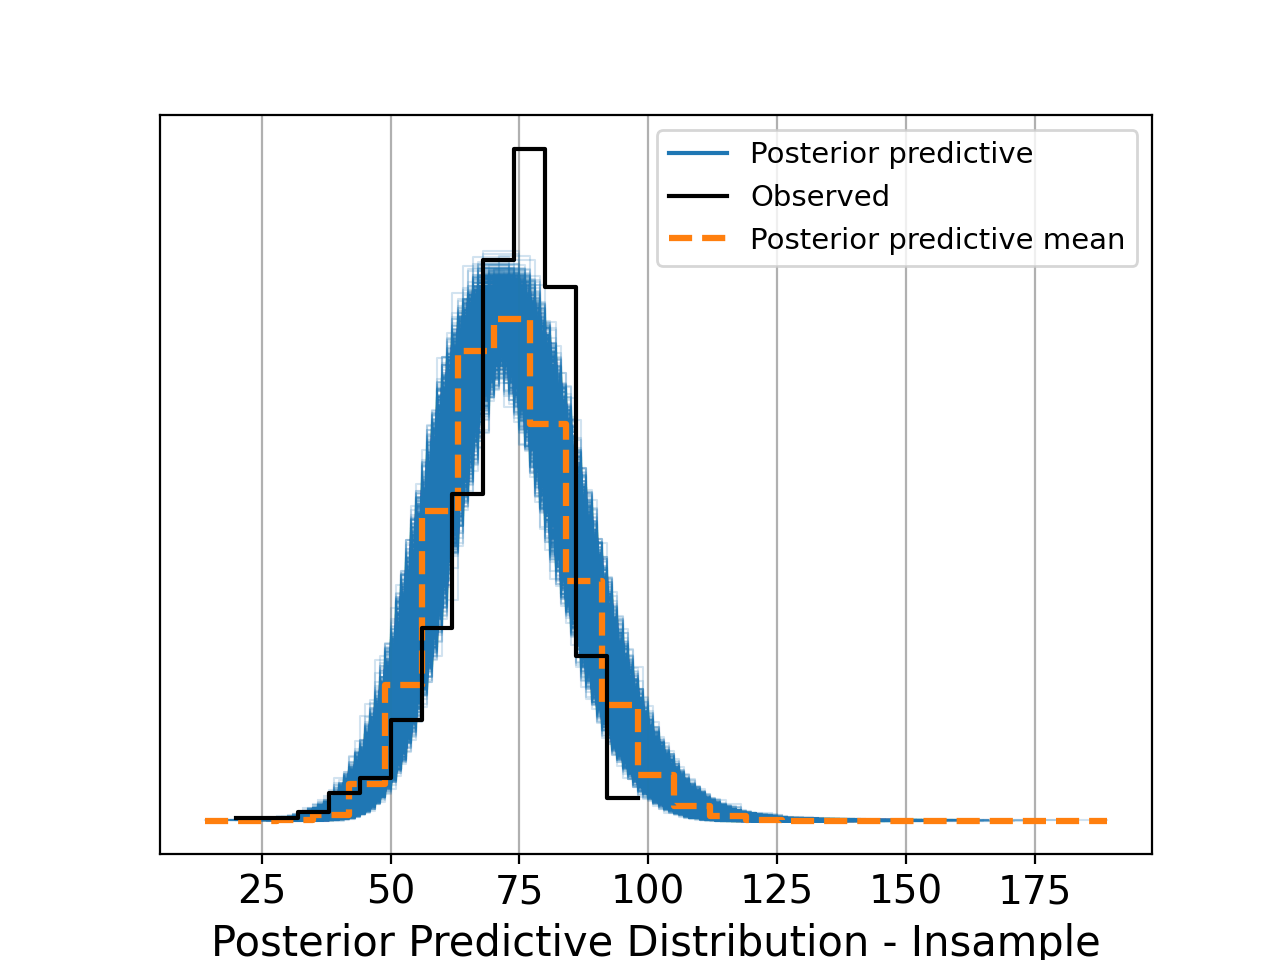

2024-04-21 17:29:52.348451	Extracting predictions
2024-04-21 17:29:52.352293	Performing manual posterior predictive inference with likelihood neg_binomial
2024-04-21 17:29:52.715147	Arviz R2 Score
2024-04-21 17:29:52.790180	Converting to dataframes
2024-04-21 17:29:52.791282	Sklearn R2 score
2024-04-21 17:29:53.595299	MAE
2024-04-21 17:29:54.129585	MSE
2024-04-21 17:29:54.651950	Combining dataframes
2024-04-21 17:29:54.654605	Preparing evaluation dictionary


In [179]:
m3_d2_eval_summary = evaluate_model(model_fit_dict = m3_d2_fit,
                                    generate_manual_predictions = True,
                                    model_likelihood_name = 'neg_binomial')

In [ ]:
m3_d2_eval_summary['error_df']

,metric,average,ste,num_obs,model
0,<function r2_score at 0x7d91d66bc8b0>,0.412515,0.006592,2794,m3_d2_basic_neg_binom_inc_embed
0,<function r2_score at 0x7d91d66bc8b0>,0.238687,0.000000,699,m3_d2_basic_neg_binom_inc_embed
0,<function r2_score at 0x7d91d4b788b0>,-1.023326,0.000903,2794,m3_d2_basic_neg_binom_inc_embed
0,<function r2_score at 0x7d91d4b788b0>,0.104476,0.000000,699,m3_d2_basic_neg_binom_inc_embed
0,<function mean_absolute_error at 0x7d91d4b78430>,11.823423,0.002800,2794,m3_d2_basic_neg_binom_inc_embed
0,<function mean_absolute_error at 0x7d91d4b78430>,7.313305,0.000000,699,m3_d2_basic_neg_binom_inc_embed
0,<function mean_squared_error at 0x7d91d4b785e0>,221.604894,0.098932,2794,m3_d2_basic_neg_binom_inc_embed
0,<function mean_squared_error at 0x7d91d4b785e0>,96.557940,0.000000,699,m3_d2_basic_neg_binom_inc_embed


### Basic Predictors with Embedding PCA

In [ ]:
# m3_d3_fit = fit_model_multivariate_neg_binom_basic(dataset_inc_embed_pca, model_name = 'm3_d3_basic_neg_binom_inc_embed_pca')

In [180]:
with open("./data/final_data/model_data_m3_d3_basic_neg_binom_inc_embed_pca.pkl", "rb") as f:
  m3_d3_fit = pickle.load(f)

In [ ]:
m3_d3_fit['model_name']

'm3_d3_basic_neg_binom_inc_embed_pca'

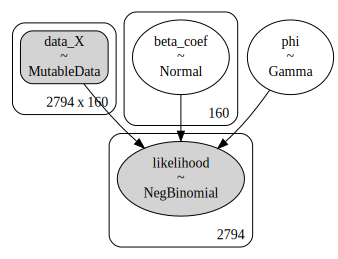

In [ ]:
pm.model_to_graphviz(m3_d3_fit['model'])

In [ ]:
m3_d3_fit_summary = check_pymc_model_fit(model_fit_dict = m3_d3_fit, var_names = ['beta', 'phi'])

<ipython-input-67-fe9c3bda71ff>:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
<ipython-input-67-fe9c3bda71ff>:13: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

              Estimate       SE
deviance_waic 20819.32    79.51
p_waic           54.19        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.


Computed from 4000 posterior samples and 2794 observations log-likelihood matrix.

             Estimate       SE
deviance_loo 20822.27    79.62
p_loo           55.67        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2786   99.7%
 (0.5, 0.7]   (ok)          3    0.1%
   (0.7, 1]   (bad)         5    0.2%
   (1, Inf)   (very bad)    0    0.0%



2024-04-21 17:29:55.356110	Extracting data from model dictionary
2024-04-21 17:29:55.357042	Extracting model object, trace, and name
2024-04-21 17:29:55.357544	Appending dummy predictor to outsample array for posterior predictive inference
2024-04-21 17:29:55.358389	Insample posterior prediction


2024-04-21 17:29:59.494392	Generating insample posterior predictive plot


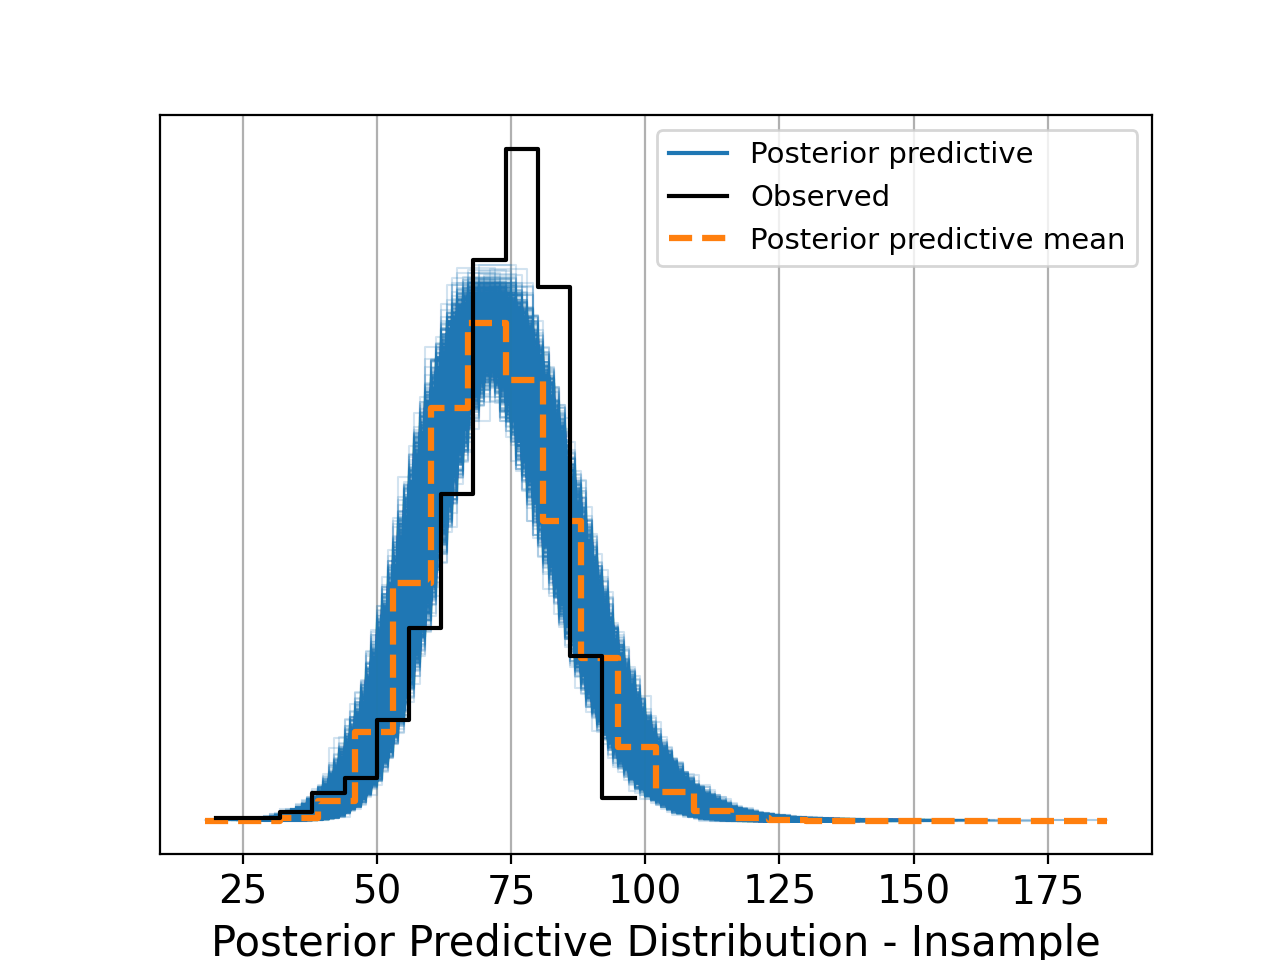

2024-04-21 17:30:08.456987	Extracting predictions
2024-04-21 17:30:08.460344	Performing manual posterior predictive inference with likelihood neg_binomial
2024-04-21 17:30:08.819630	Arviz R2 Score
2024-04-21 17:30:08.932931	Converting to dataframes
2024-04-21 17:30:08.934004	Sklearn R2 score
2024-04-21 17:30:09.743279	MAE
2024-04-21 17:30:10.287855	MSE
2024-04-21 17:30:10.829787	Combining dataframes
2024-04-21 17:30:10.832245	Preparing evaluation dictionary


In [181]:
m3_d3_eval_summary = evaluate_model(model_fit_dict = m3_d3_fit,
                                    generate_manual_predictions = True,
                                    model_likelihood_name = 'neg_binomial')

In [ ]:
m3_d3_eval_summary['error_df']

,metric,average,ste,num_obs,model
0,<function r2_score at 0x7d91d66bc8b0>,0.431765,0.006878,2794,m3_d3_basic_neg_binom_inc_embed_pca
0,<function r2_score at 0x7d91d66bc8b0>,0.302726,0.000000,699,m3_d3_basic_neg_binom_inc_embed_pca
0,<function r2_score at 0x7d91d4b788b0>,-0.973286,0.000889,2794,m3_d3_basic_neg_binom_inc_embed_pca
0,<function r2_score at 0x7d91d4b788b0>,0.150358,0.000000,699,m3_d3_basic_neg_binom_inc_embed_pca
0,<function mean_absolute_error at 0x7d91d4b78430>,11.672852,0.002784,2794,m3_d3_basic_neg_binom_inc_embed_pca
0,<function mean_absolute_error at 0x7d91d4b78430>,7.044349,0.000000,699,m3_d3_basic_neg_binom_inc_embed_pca
0,<function mean_squared_error at 0x7d91d4b785e0>,216.124346,0.097336,2794,m3_d3_basic_neg_binom_inc_embed_pca
0,<function mean_squared_error at 0x7d91d4b785e0>,91.610873,0.000000,699,m3_d3_basic_neg_binom_inc_embed_pca


# Model Comparison

Bayesian Model specific metrics
1. WAIC
2. LOO
3. Pareto K distribution in case of WAIC
4. Fit times
5. `r_hat` and `ess_bulk` distributions

Across all models (insample and outsample)
- R2 score
- Mean absolute error
- Mean squared error

## Functions


In [182]:
def extract_id_from_name(model_name, regex):
  """Simple function for extracting model/data ID from model_name"""
  regex_match = re.search(regex, model_name)
  if regex_match:
    return regex_match.group(0)
  else:
    return 'NA'

In [183]:
def extract_metric_name(metric_str):
  metric_match = re.search(r'<function (\w+) at', metric_str)
  if metric_match:
    return metric_match.group(1)
  else:
    return None

## WAIC

In [ ]:
waic_df = pd.concat([
    # Model 1 - Truncated Normal Likelihood
    m1_d1_fit_summary['waic'], m1_d2_fit_summary['waic'], m1_d3a_fit_summary['waic'],

    # Model 2 - Poisson Likelihood
    m2_d1_fit_summary['waic'], m2_d2_fit_summary['waic'], m2_d3_fit_summary['waic'],

    # Model 3 - Negative Binomial Likelihood
    m3_d1_fit_summary['waic'], m3_d2_fit_summary['waic'], m3_d3_fit_summary['waic']
])

waic_df['model_id'] = waic_df['model_name'].apply(lambda x: extract_id_from_name(x, '^m[1-3]'))
waic_df['dataset_id'] = waic_df['model_name'].apply(lambda x: extract_id_from_name(x, 'd[1-3]'))

In [ ]:
waic_df

,elpd_waic,se,p_waic,n_samples,n_data_points,warning,waic_i,scale,model_name,model_id,dataset_id
0,20533.897471,93.17973,34.331692,4000,2794,True,[<xarray.DataArray 'waic_i' ()>\narray(9.51454...,deviance,m1_d1_basic_norm_basic_preds,m1,d1
0,20480.384797,91.713167,37.939645,4000,2794,True,[<xarray.DataArray 'waic_i' ()>\narray(9.96930...,deviance,m1_d2_basic_norm_inc_embed_point_estimates,m1,d2
0,20361.374923,93.929974,80.768587,4000,2794,True,[<xarray.DataArray 'waic_i' ()>\narray(10.6443...,deviance,m1_d3_basic_norm_embed_pca_pymc_sampler,m1,d3
0,20865.425244,142.592284,42.1064,4000,2794,True,[<xarray.DataArray 'waic_i' ()>\narray(10.0808...,deviance,m2_d1_basic_poisson_basic_preds,m2,d1
0,20775.616758,136.378157,31.034704,4000,2794,True,[<xarray.DataArray 'waic_i' ()>\narray(10.3588...,deviance,m2_d2_basic_poisson_inc_embed_point_estimates,m2,d2
0,20653.878199,134.918025,91.429275,4000,2794,True,[<xarray.DataArray 'waic_i' ()>\narray(11.1182...,deviance,m2_d3_poisson_basic_preds_inc_embed_pca,m2,d3
0,20923.207751,82.500449,25.52211,4000,2794,True,[<xarray.DataArray 'waic_i' ()>\narray(9.03006...,deviance,m3_d1_basic_neg_binom_basic_preds_correct_shape,m3,d1
0,20881.516134,80.676534,28.404472,4000,2794,True,[<xarray.DataArray 'waic_i' ()>\narray(9.31516...,deviance,m3_d2_basic_neg_binom_inc_embed,m3,d2
0,20819.3199,79.513504,54.188484,4000,2794,True,[<xarray.DataArray 'waic_i' ()>\narray(9.63599...,deviance,m3_d3_basic_neg_binom_inc_embed_pca,m3,d3


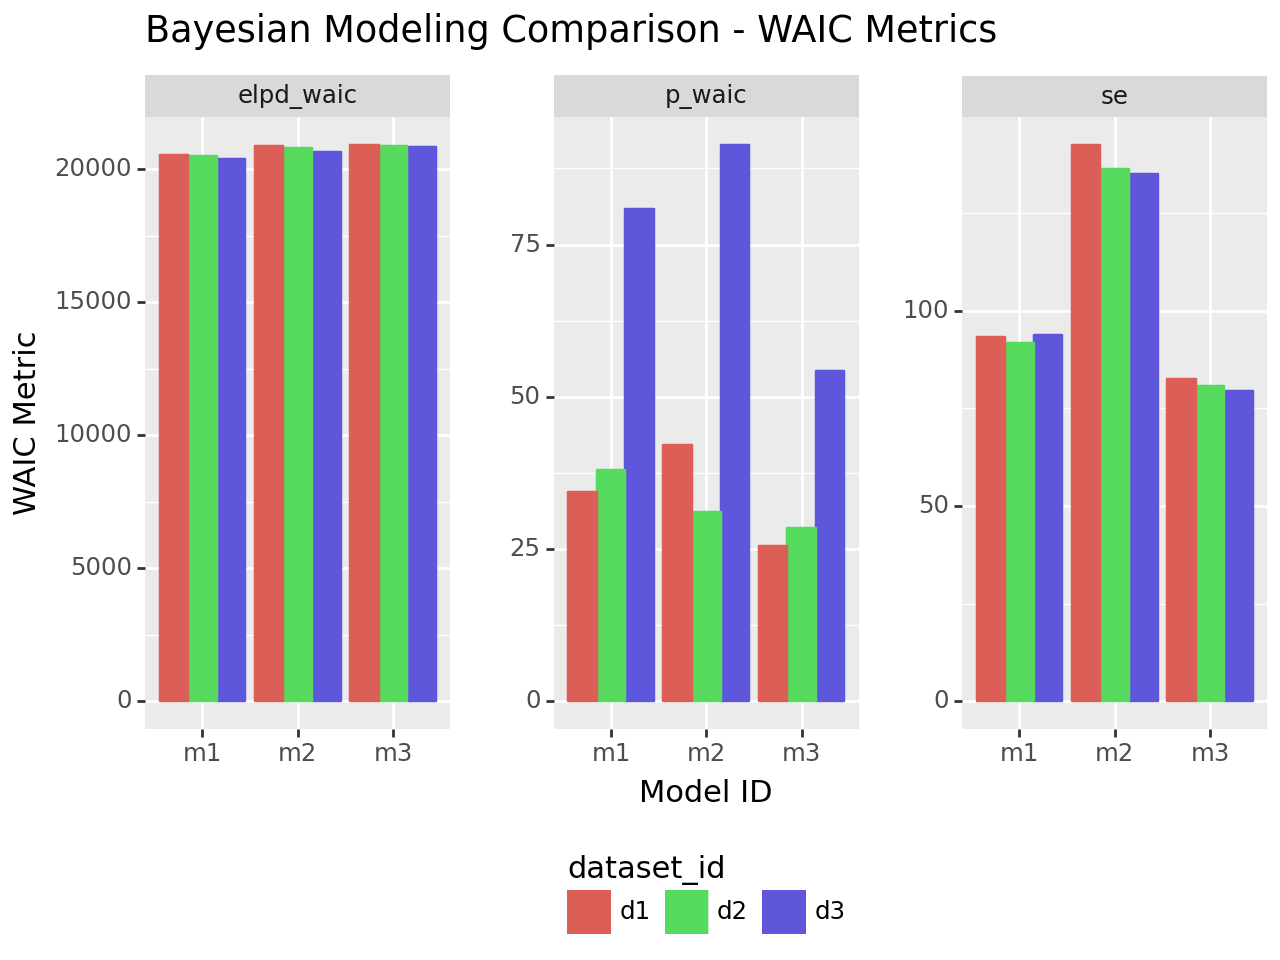

<Figure Size: (640 x 480)>

In [ ]:
waic_df_long = waic_df[['model_id', 'dataset_id', 'elpd_waic', 'se', 'p_waic']].melt(['model_id', 'dataset_id'])
waic_df_long['value'] = waic_df_long['value'].astype(float)
(
    pn.ggplot(waic_df_long, pn.aes(x = 'model_id', y = 'value', fill = 'dataset_id', color = 'dataset_id', group = 'dataset_id'))
    + pn.geom_col(position = 'dodge')
    + pn.facet_wrap('~ variable', scales = 'free', nrow = 1)
    + pn.labs(x = 'Model ID', y = 'WAIC Metric', title = 'Bayesian Modeling Comparison - WAIC Metrics')
    + pn.theme(legend_position = 'bottom')
)

## LOO

In [ ]:
loo_df = pd.concat([
    # Model 1 - Truncated Normal Likelihood
    m1_d1_fit_summary['loo'], m1_d2_fit_summary['loo'],  m1_d3a_fit_summary['loo'], # m1_d3_fit_summary['loo'],

    # Model 2 - Poisson Likelihood
    m2_d1_fit_summary['loo'], m2_d2_fit_summary['loo'], m2_d3_fit_summary['loo'],

    # Model 3 - Negative Binomial Likelihood
    m3_d1_fit_summary['loo'], m3_d2_fit_summary['loo'], m3_d3_fit_summary['loo']
])

loo_df['model_id'] = loo_df['model_name'].apply(lambda x: extract_id_from_name(x, '^m[1-3]'))
loo_df['dataset_id'] = loo_df['model_name'].apply(lambda x: extract_id_from_name(x, 'd[1-3]'))

In [ ]:
loo_df

,elpd_loo,se,p_loo,n_samples,n_data_points,warning,loo_i,pareto_k,scale,model_name,model_id,dataset_id
0,20536.793234,93.322944,35.779573,4000,2794,True,[<xarray.DataArray 'loo_i' ()>\narray(9.514594...,[<xarray.DataArray 'pareto_shape' ()>\narray(-...,deviance,m1_d1_basic_norm_basic_preds,m1,d1
0,20482.753206,91.833964,39.12385,4000,2794,True,[<xarray.DataArray 'loo_i' ()>\narray(9.969387...,[<xarray.DataArray 'pareto_shape' ()>\narray(0...,deviance,m1_d2_basic_norm_inc_embed_point_estimates,m1,d2
0,20364.553285,94.034245,82.357768,4000,2794,True,[<xarray.DataArray 'loo_i' ()>\narray(10.64444...,[<xarray.DataArray 'pareto_shape' ()>\narray(-...,deviance,m1_d3_basic_norm_embed_pca_pymc_sampler,m1,d3
0,20870.617585,142.746706,44.702571,4000,2794,True,[<xarray.DataArray 'loo_i' ()>\narray(10.08093...,[<xarray.DataArray 'pareto_shape' ()>\narray(-...,deviance,m2_d1_basic_poisson_basic_preds,m2,d1
0,20779.97043,136.680077,33.21154,4000,2794,True,[<xarray.DataArray 'loo_i' ()>\narray(10.35911...,[<xarray.DataArray 'pareto_shape' ()>\narray(-...,deviance,m2_d2_basic_poisson_inc_embed_point_estimates,m2,d2
0,20656.458387,134.910077,92.719369,4000,2794,True,[<xarray.DataArray 'loo_i' ()>\narray(11.11837...,[<xarray.DataArray 'pareto_shape' ()>\narray(-...,deviance,m2_d3_poisson_basic_preds_inc_embed_pca,m2,d3
0,20927.187836,82.66161,27.512152,4000,2794,True,[<xarray.DataArray 'loo_i' ()>\narray(9.030106...,[<xarray.DataArray 'pareto_shape' ()>\narray(-...,deviance,m3_d1_basic_neg_binom_basic_preds_correct_shape,m3,d1
0,20883.459185,80.712785,29.375997,4000,2794,True,[<xarray.DataArray 'loo_i' ()>\narray(9.315214...,[<xarray.DataArray 'pareto_shape' ()>\narray(-...,deviance,m3_d2_basic_neg_binom_inc_embed,m3,d2
0,20822.273804,79.618905,55.665435,4000,2794,True,[<xarray.DataArray 'loo_i' ()>\narray(9.636071...,[<xarray.DataArray 'pareto_shape' ()>\narray(-...,deviance,m3_d3_basic_neg_binom_inc_embed_pca,m3,d3


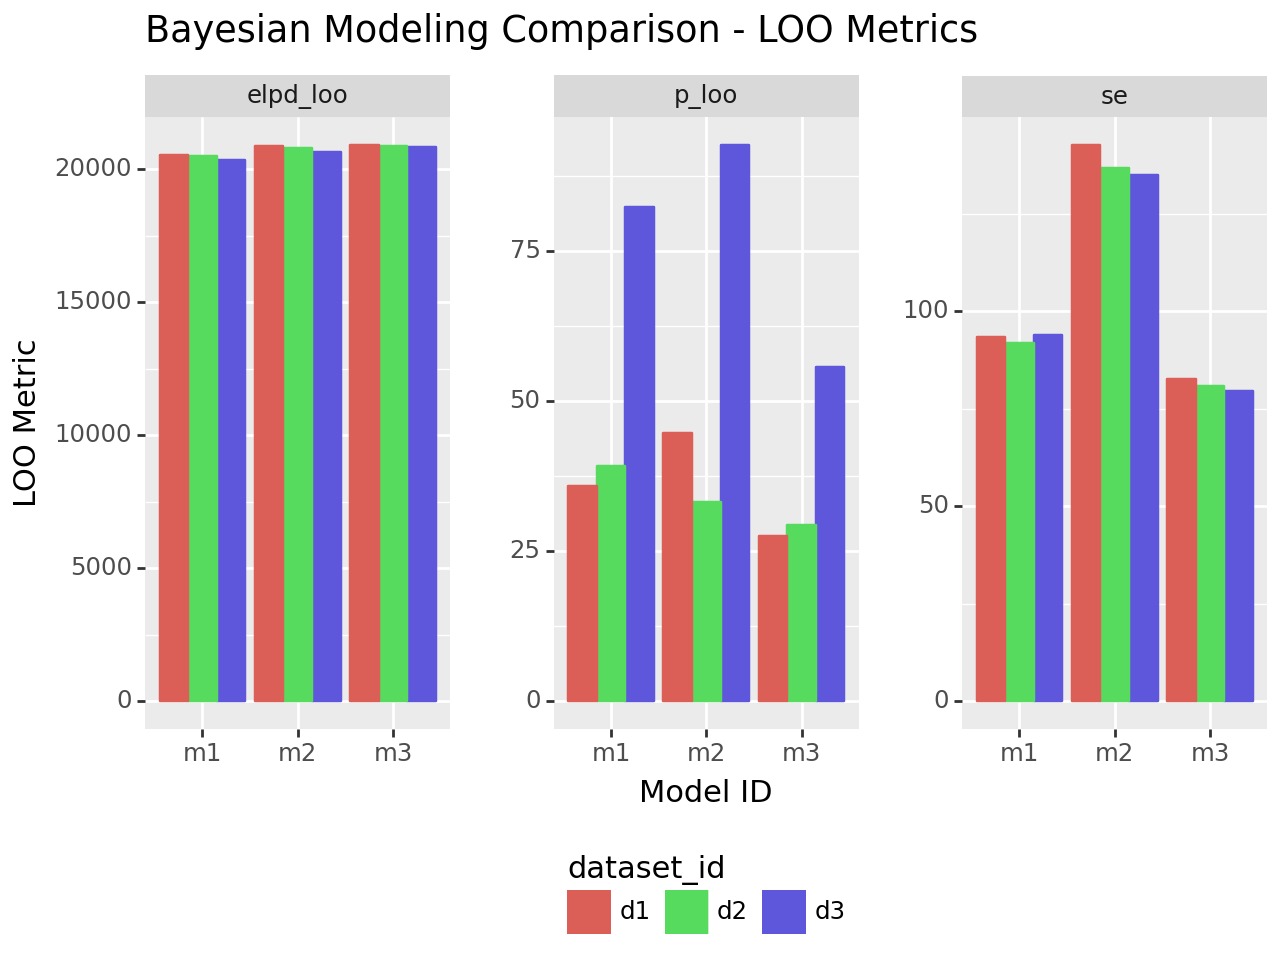

<Figure Size: (640 x 480)>

In [ ]:
loo_df_long = loo_df[['model_id', 'dataset_id', 'elpd_loo', 'se', 'p_loo']].melt(['model_id', 'dataset_id'])
loo_df_long['value'] = loo_df_long['value'].astype(float)
(
    pn.ggplot(loo_df_long, pn.aes(x = 'model_id', y = 'value', fill = 'dataset_id', color = 'dataset_id', group = 'dataset_id'))
    + pn.geom_col(position = 'dodge')
    + pn.facet_wrap('~ variable', scales = 'free', nrow = 1)
    + pn.labs(x = 'Model ID', y = 'LOO Metric', title = 'Bayesian Modeling Comparison - LOO Metrics')
    + pn.theme(legend_position = 'bottom')
)

## Pareto-K Distribution

Haven't been able to find a programmatic way of extracting the Pareto-K statistic sample distribution by bucket.

Creating it manually from data printed to console. **bold text**

In [ ]:
pareto_k_data = {
    ('m1', 'd1'): {'(-inf, 0.5]': 2785, '(0.5, 0.7]': 5, '(0.7, 1]': 4, '(1, inf)': 0},
    ('m1', 'd2'): {'(-inf, 0.5]': 2784, '(0.5, 0.7]': 5, '(0.7, 1]': 5, '(1, inf)': 0},
    ('m1', 'd3'): {'(-inf, 0.5]': 2787, '(0.5, 0.7]': 6, '(0.7, 1]': 1, '(1, inf)': 0},
    ('m2', 'd1'): {'(-inf, 0.5]': 2783, '(0.5, 0.7]': 5, '(0.7, 1]': 5, '(1, inf)': 1},
    ('m2', 'd2'): {'(-inf, 0.5]': 2752, '(0.5, 0.7]': 23, '(0.7, 1]': 17, '(1, inf)': 2},
    ('m2', 'd3'): {'(-inf, 0.5]': 2784, '(0.5, 0.7]': 6, '(0.7, 1]': 4, '(1, inf)': 0},
    ('m3', 'd1'): {'(-inf, 0.5]': 2784, '(0.5, 0.7]': 5, '(0.7, 1]': 4, '(1, inf)': 1},
    ('m3', 'd2'): {'(-inf, 0.5]': 2787, '(0.5, 0.7]': 4, '(0.7, 1]': 2, '(1, inf)': 1},
    ('m3', 'd3'): {'(-inf, 0.5]': 2786, '(0.5, 0.7]': 3, '(0.7, 1]': 5, '(1, inf)': 0}
}

# Convert the dictionary to a pandas DataFrame
pareto_k_df = pd.DataFrame(pareto_k_data).T.rename_axis(['Model', 'Dataset']).reset_index()

In [ ]:
pareto_k_df

,Model,Dataset,"(-inf, 0.5]","(0.5, 0.7]","(0.7, 1]","(1, inf)"
0,m1,d1,2785,5,4,0
1,m1,d2,2784,5,5,0
2,m1,d3,2787,6,1,0
3,m2,d1,2783,5,5,1
4,m2,d2,2752,23,17,2
5,m2,d3,2784,6,4,0
6,m3,d1,2784,5,4,1
7,m3,d2,2787,4,2,1
8,m3,d3,2786,3,5,0


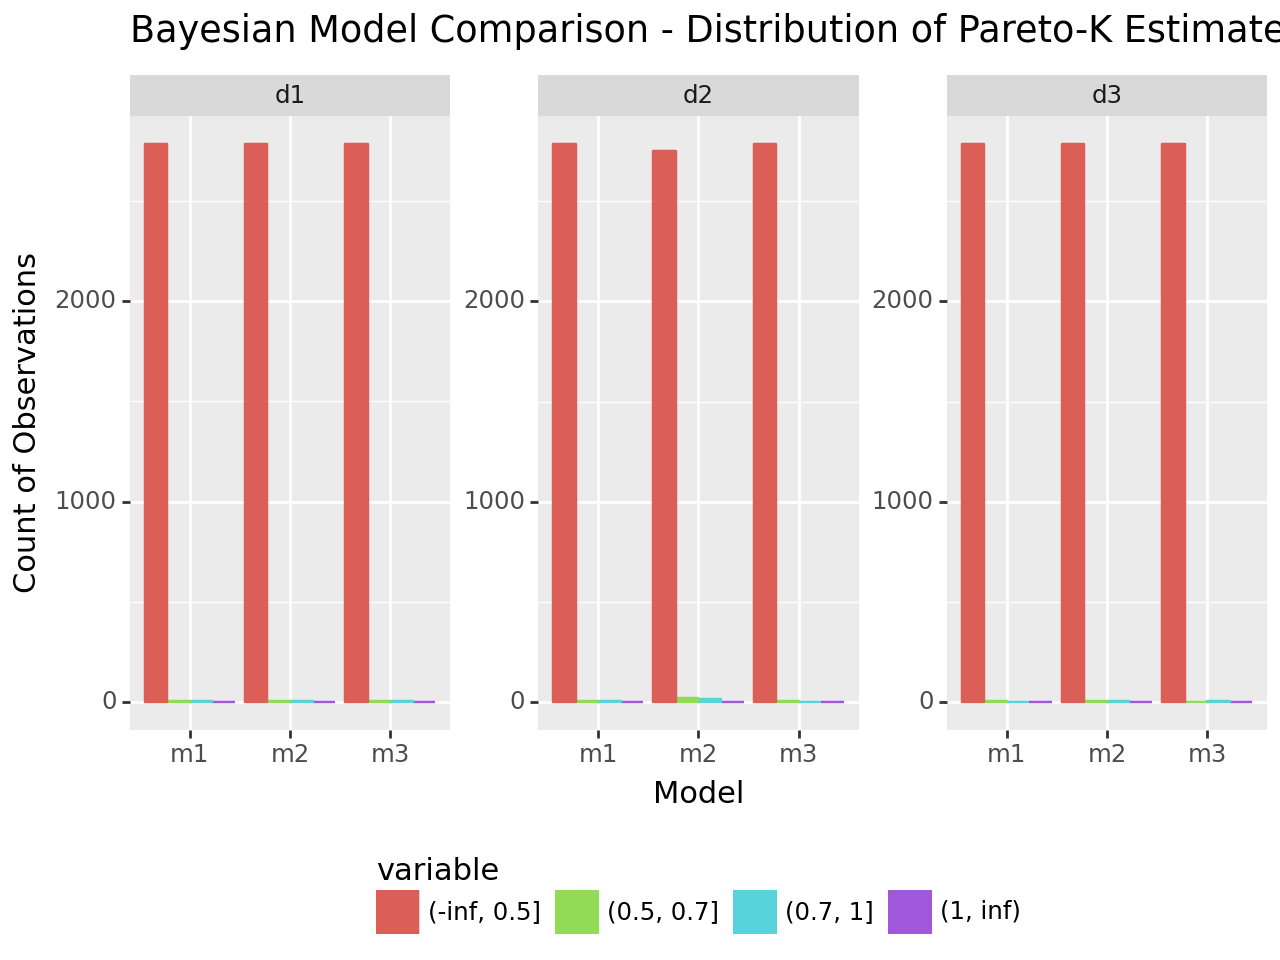

<Figure Size: (640 x 480)>

In [ ]:
pareto_k_df_long = pareto_k_df.melt(['Model', 'Dataset'])

(
    pn.ggplot(pareto_k_df_long, pn.aes(x = 'Model', y = 'value', color = 'variable', fill = 'variable'))
    + pn.geom_col(position = 'dodge')
    + pn.facet_wrap(' ~ Dataset', scales = 'free')
    + pn.labs(x = 'Model', y = 'Count of Observations', title = 'Bayesian Model Comparison - Distribution of Pareto-K Estimates')
    + pn.theme(legend_position = 'bottom')
)

## Fit Times

I fit the normal models before adding a `t_fit` attribute to the returned result set.

Imputing these values manually based on PyMC logs / traces from the notebooks.

In [ ]:
m1_d1_fit['t_fit'] = 14.5
m1_d2_fit['t_fit'] = 34
m1_d3_fit['t_fit'] = 8            # T4 GPU!
m1_d3a_fit['t_fit'] = 187

In [ ]:
model_fits = [m1_d1_fit, m1_d2_fit, m1_d3a_fit, # m1_d3_fit,
              m2_d1_fit, m2_d2_fit, m2_d3_fit,
              m3_d1_fit, m3_d2_fit, m3_d3_fit]

In [ ]:
fit_times_df = pd.DataFrame({
    'model_name': [x['model_name'] for x in model_fits],
    't_fit': [x['t_fit'] for x in model_fits]
})

In [ ]:
fit_times_df['model_id'] = fit_times_df['model_name'].apply(lambda x: extract_id_from_name(x, r'^m[1-3]'))
fit_times_df['dataset_id'] = fit_times_df['model_name'].apply(lambda x: extract_id_from_name(x, r'd[1-3]'))

In [ ]:
fit_times_df

,model_name,t_fit,model_id,dataset_id
0,m1_d1_basic_norm_basic_preds,14.500000,m1,d1
1,m1_d2_basic_norm_inc_embed_point_estimates,34.000000,m1,d2
2,m1_d3_basic_norm_embed_pca_pymc_sampler,187.000000,m1,d3
3,m2_d1_basic_poisson_basic_preds,39.767874,m2,d1
4,m2_d2_basic_poisson_inc_embed_point_estimates,34.100878,m2,d2
5,m2_d3_poisson_basic_preds_inc_embed_pca,73.928954,m2,d3
6,m3_d1_basic_neg_binom_basic_preds_correct_shape,90.956013,m3,d1
7,m3_d2_basic_neg_binom_inc_embed,95.941852,m3,d2
8,m3_d3_basic_neg_binom_inc_embed_pca,128.862707,m3,d3


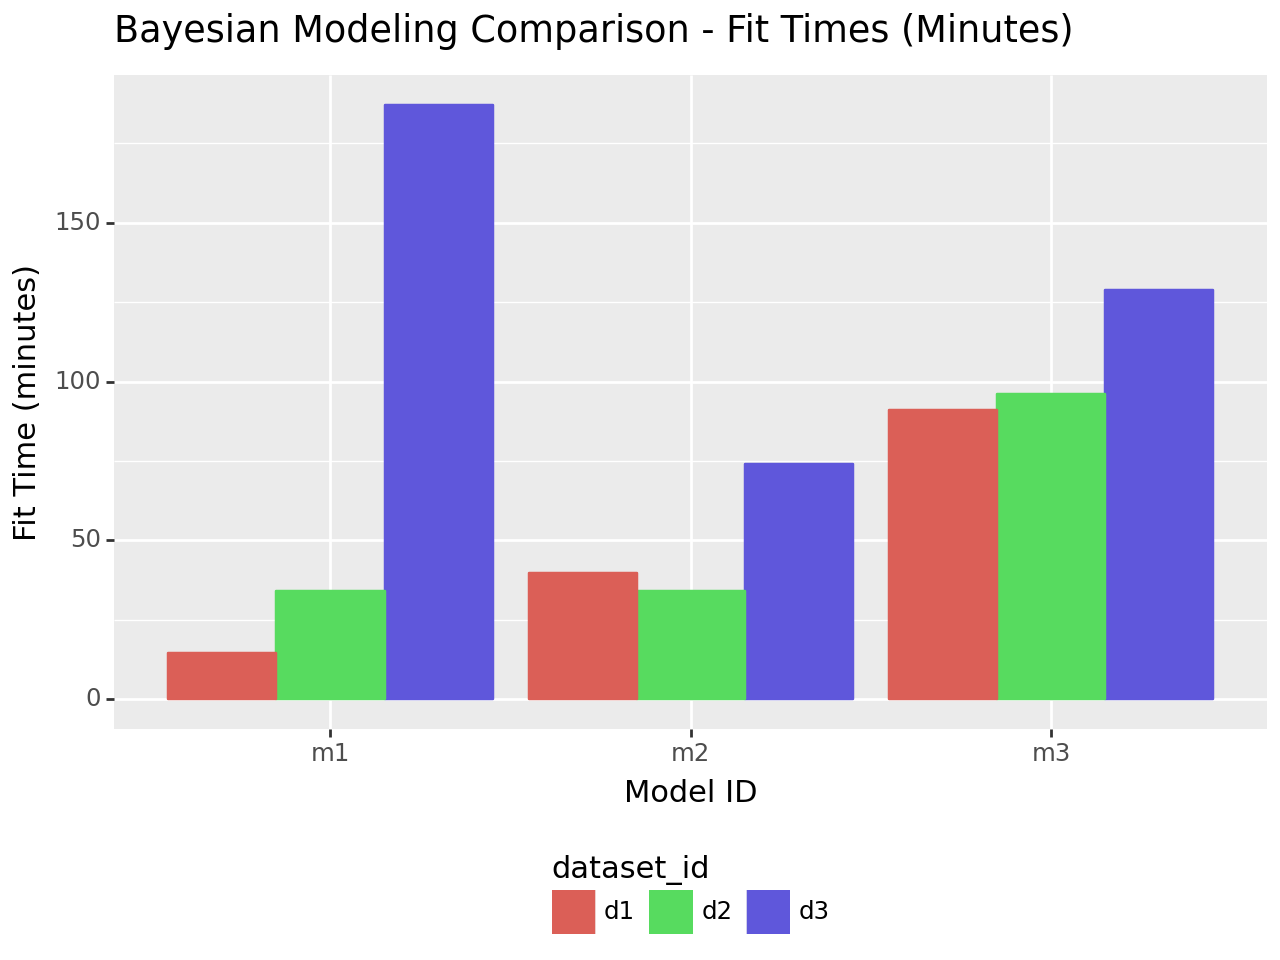

<Figure Size: (640 x 480)>

In [ ]:
(
    pn.ggplot(fit_times_df, pn.aes(x = 'model_id', y = 't_fit', color = 'dataset_id', fill = 'dataset_id', group = 'dataset_id'))
    + pn.geom_col(position = 'dodge')
    + pn.labs(x = 'Model ID', y = 'Fit Time (minutes)', title = 'Bayesian Modeling Comparison - Fit Times (Minutes)')
    + pn.theme(legend_position = 'bottom')
)

## `r_hat` and `ess_bulk` distributions

In [ ]:
m1_d1_fit_summary.keys()

dict_keys(['model_name', 'waic', 'loo', 'trace_summary', 'rhat_ess_df'])

In [ ]:
rhat_ess_df_all = pd.concat([
    m1_d1_fit_summary['rhat_ess_df'], m1_d2_fit_summary['rhat_ess_df'], m1_d3a_fit_summary['rhat_ess_df'],
    m2_d1_fit_summary['rhat_ess_df'], m2_d2_fit_summary['rhat_ess_df'], m2_d3_fit_summary['rhat_ess_df'],
    m3_d3_fit_summary['rhat_ess_df'], m3_d2_fit_summary['rhat_ess_df'], m3_d3_fit_summary['rhat_ess_df']
])

rhat_ess_df_all['model_id'] = rhat_ess_df_all['model_name'].apply(lambda x: extract_id_from_name(x, r'^m[1-3]'))
rhat_ess_df_all['dataset_id'] = rhat_ess_df_all['model_name'].apply(lambda x: extract_id_from_name(x, r'd[1-3]'))

In [ ]:
rhat_ess_df_all.groupby(['model_name', 'model_id', 'dataset_id'])['r_hat'].count()

model_name                                     model_id  dataset_id
m1_d1_basic_norm_basic_preds                   m1        d1             33
m1_d2_basic_norm_inc_embed_point_estimates     m1        d2             39
m1_d3_basic_norm_embed_pca_pymc_sampler        m1        d3            161
m2_d1_basic_poisson_basic_preds                m2        d1             32
m2_d2_basic_poisson_inc_embed_point_estimates  m2        d2             38
m2_d3_poisson_basic_preds_inc_embed_pca        m2        d3            160
m3_d2_basic_neg_binom_inc_embed                m3        d2             39
m3_d3_basic_neg_binom_inc_embed_pca            m3        d3            322
Name: r_hat, dtype: int64

In [ ]:
rhat_ess_df_all_long = rhat_ess_df_all[['model_id', 'dataset_id', 'r_hat', 'ess_bulk']].melt(['model_id', 'dataset_id'])

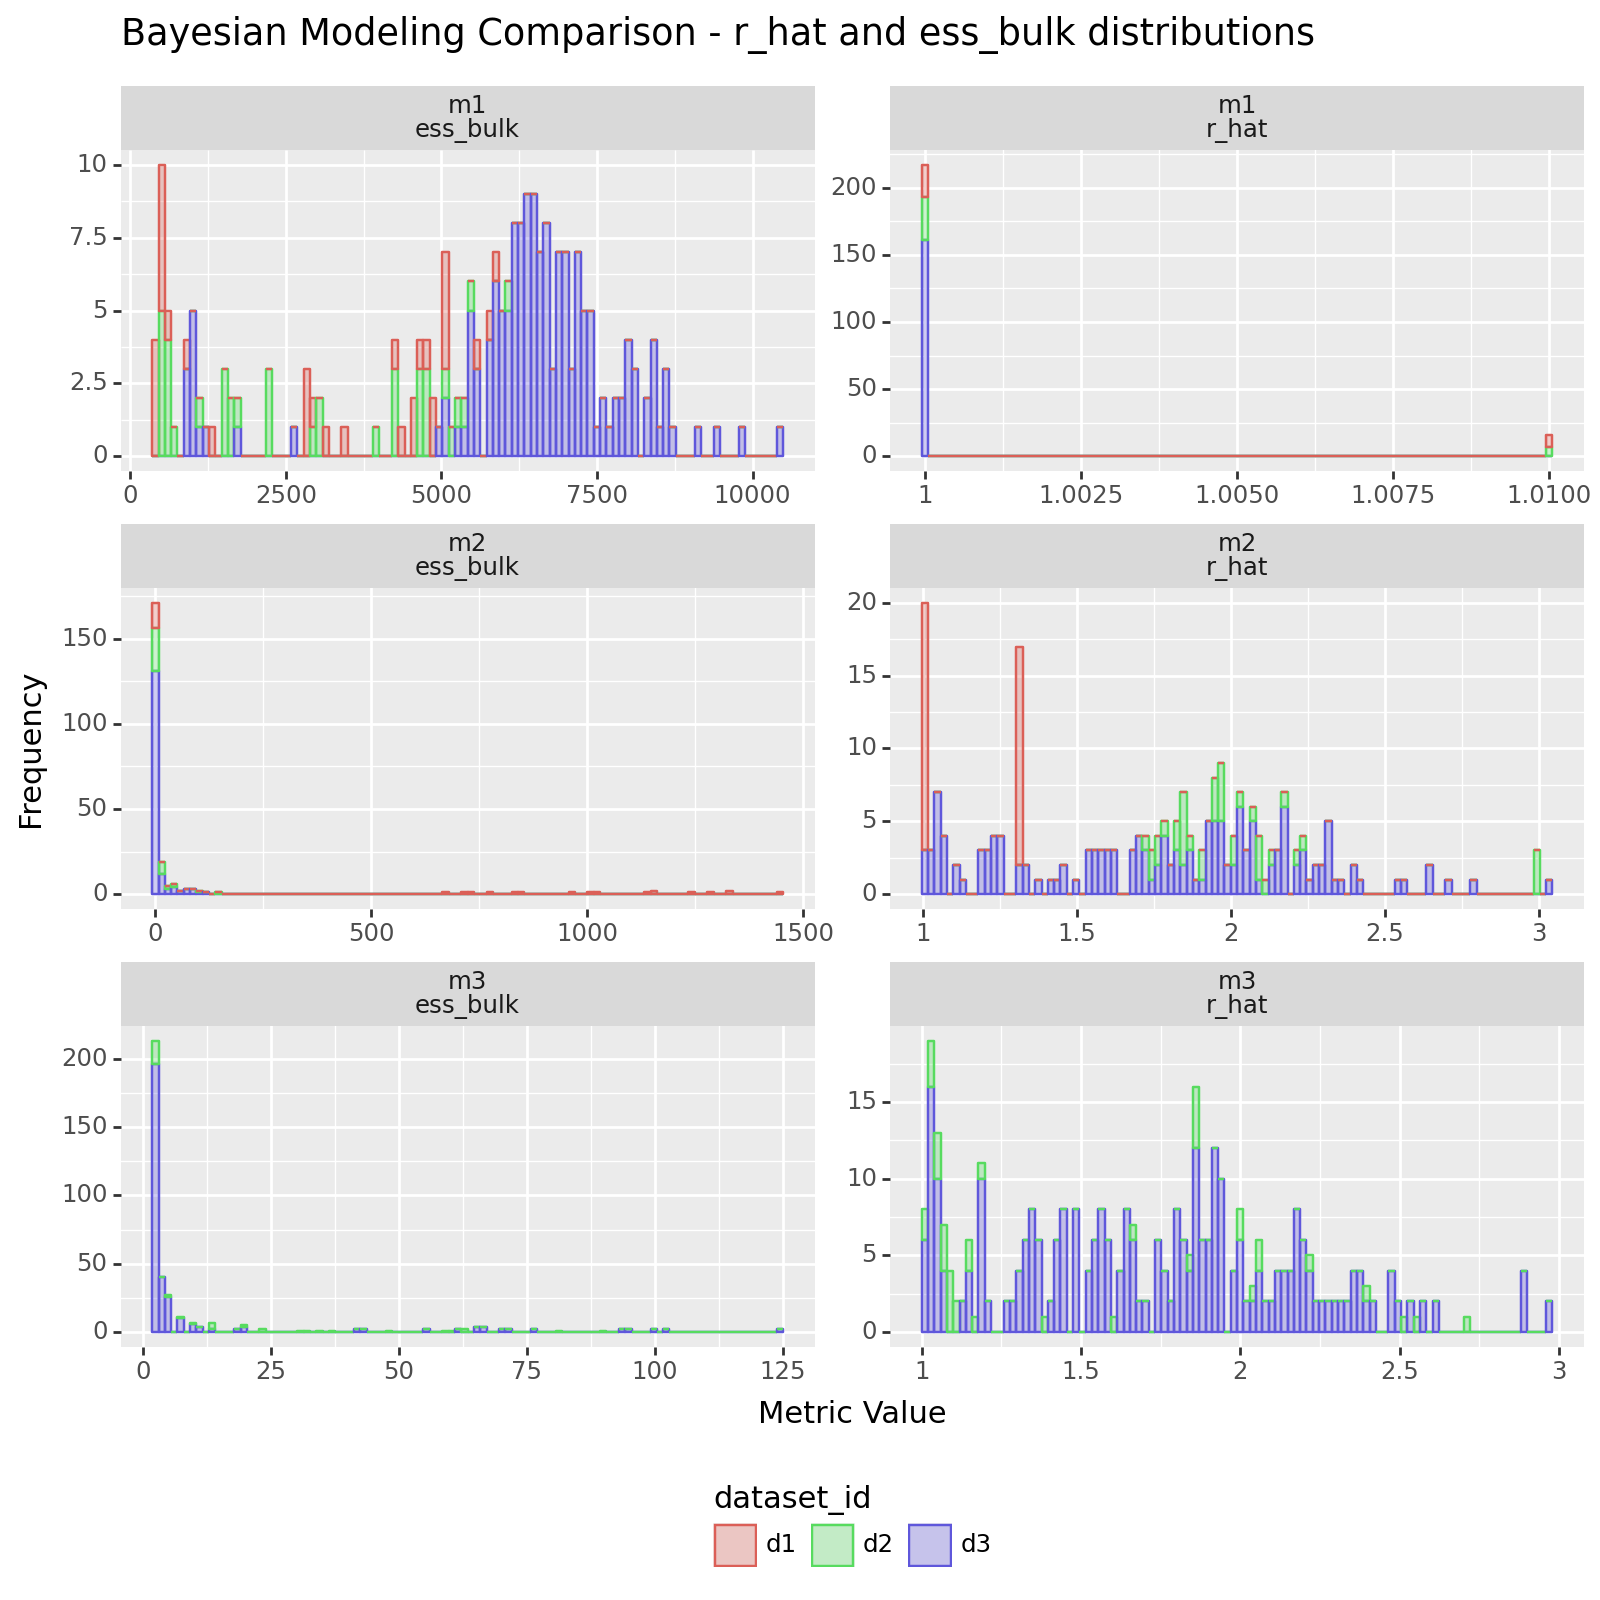

<Figure Size: (800 x 800)>

In [ ]:
(
    pn.ggplot(rhat_ess_df_all_long, pn.aes(x = 'value', color = 'dataset_id', group = 'dataset_id', fill = 'dataset_id'))
    + pn.geom_histogram(bins = 100, alpha = 0.3)
    # + pn.geom_density(alpha = 0.3)
    # + pn.facet_grid('model_id ~ variable', scales = 'free')
    + pn.facet_wrap(' ~ model_id + variable', scales = 'free', nrow = 3)
    + pn.labs(x = 'Metric Value', y = 'Frequency', title = 'Bayesian Modeling Comparison - r_hat and ess_bulk distributions')
    + pn.theme(legend_position = 'bottom', figure_size = (8, 8))
)

In [ ]:
# Find point mean / median and quantiles for each metric for each dataset and model id
rhat_ess_summary_df = rhat_ess_df_all.groupby(['model_id', 'dataset_id']).agg({
    'r_hat': ['mean', lambda x: x.quantile(0.05), lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75), lambda x: x.quantile(0.95)],
    'ess_bulk': ['mean', lambda x: x.quantile(0.05), lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75), lambda x: x.quantile(0.95)]
})

# Rename columns for clarity
rhat_ess_summary_df.columns = ['r_hat_mean', 'r_hat_5th_quantile', 'r_hat_25th_quantile', 'r_hat_50th_quantile', 'r_hat_75th_quantile', 'r_hat_95th_quantile',
                      'ess_bulk_mean', 'ess_bulk_5th_quantile', 'ess_bulk_25th_quantile', 'ess_bulk_50th_quantile', 'ess_bulk_75th_quantile', 'ess_bulk_95th_quantile']


In [ ]:
rhat_ess_summary_df

r_hat_mean  r_hat_5th_quantile  r_hat_25th_quantile  \
model_id dataset_id                                                        
m1       d1            1.002727              1.0000               1.0000   
         d2            1.001795              1.0000               1.0000   
         d3            1.000000              1.0000               1.0000   
m2       d1            1.145312              1.0000               1.0000   
         d2            2.026579              1.7485               1.8400   
         d3            1.774625              1.0400               1.4275   
m3       d2            1.515897              1.0190               1.0650   
         d3            1.736273              1.0200               1.3700   

                     r_hat_50th_quantile  r_hat_75th_quantile  \
model_id dataset_id                                             
m1       d1                        1.000                 1.01   
         d2                        1.000                 1.00   
         d3                        1.000                 1.00   
m2       d1                        1.000                 1.31   
         d2                        1.955                 2.09   
         d3                        1.825                 2.08   
m3       d2                        1.160                 1.93   
         d3                        1.770                 2.03   

                     r_hat_95th_quantile  ess_bulk_mean  \
model_id dataset_id                                       
m1       d1                       1.0100    3014.000000   
         d2                       1.0100    2808.615385   
         d3                       1.0000    6404.012422   
m2       d1                       1.3100     554.468750   
         d2                       2.9900      14.947368   
         d3                       2.4005      10.150000   
m3       d2                       2.5150      20.615385   
         d3                       2.4700      11.086957   

                     ess_bulk_5th_quantile  ess_bulk_25th_quantile  \
model_id dataset_id                                                  
m1       d1                          435.6                   523.0   
         d2                          525.5                   950.0   
         d3                         1102.0                  6032.0   
m2       d1                            6.0                     6.0   
         d2                            2.0                     3.0   
         d3                            2.0                     3.0   
m3       d2                            2.0                     3.0   
         d3                            2.0                     3.0   

                     ess_bulk_50th_quantile  ess_bulk_75th_quantile  \
model_id dataset_id                                                   
m1       d1                          3093.0                 4898.00   
         d2                          2261.0                 4677.00   
         d3                          6571.0                 7215.00   
m2       d1                           694.0                 1056.75   
         d2                             3.0                   15.50   
         d3                             3.0                    4.00   
m3       d2                            10.0                   31.50   
         d3                             3.0                    5.00   

                     ess_bulk_95th_quantile  
model_id dataset_id                          
m1       d1                         5660.80  
         d2                         5366.30  
         d3                         8528.00  
m2       d1                         1334.45  
         d2                           51.65  
         d3                           60.40  
m3       d2                           64.80  
         d3                           66.00

## Error Comparison

### Bayesian Results Preprocessing

In [184]:
error_df_bayesian_all = pd.concat([
    m1_d1_eval_summary['error_df'], m1_d2_eval_summary['error_df'], m1_d3a_eval_summary['error_df'],
    m2_d1_eval_summary['error_df'], m2_d2_eval_summary['error_df'], m2_d3_eval_summary['error_df'],
    m3_d1_eval_summary['error_df'], m3_d2_eval_summary['error_df'], m3_d3_eval_summary['error_df']
])

In [187]:
# Drop the erroneous R2 score
# Address of the r2_score is likely to change on future executions of the notebook
error_df_bayesian_all = error_df_bayesian_all.loc[error_df_bayesian_all['metric'] != '<function r2_score at 0x7f7f648c65f0>']

In [188]:
error_df_bayesian_all.head()

,metric,average,ste,num_obs,model
0,<function r2_score at 0x7f7f66362170>,0.380364,0.007055,2794,m1_d1_basic_norm_basic_preds
0,<function r2_score at 0x7f7f66362170>,0.437425,0.047410,699,m1_d1_basic_norm_basic_preds
0,<function mean_absolute_error at 0x7f7f648c6170>,10.647059,0.002452,2794,m1_d1_basic_norm_basic_preds
0,<function mean_absolute_error at 0x7f7f648c6170>,57.251721,0.082315,699,m1_d1_basic_norm_basic_preds
0,<function mean_squared_error at 0x7f7f648c6320>,181.239931,0.076066,2794,m1_d1_basic_norm_basic_preds


In [189]:
# Extract the name of the metric from the function
error_df_bayesian_all['metric_extract'] = error_df_bayesian_all['metric'].apply(extract_metric_name)

In [190]:
# Make an insample/outsample label for each row
error_df_bayesian_all['metric_type'] = 'insample'
error_df_bayesian_all.loc[error_df_bayesian_all['num_obs'] != 2794, 'metric_type'] = 'outsample'

In [191]:
error_df_bayesian_all.groupby(['metric_extract', 'metric_type'])['num_obs'].agg(['count', 'mean'])

count    mean
metric_extract      metric_type               
mean_absolute_error insample         9  2794.0
                    outsample        9   699.0
mean_squared_error  insample         9  2794.0
                    outsample        9   699.0
r2_score            insample         9  2794.0
                    outsample        9   699.0

In [192]:
all_results_bayesian_subset = error_df_bayesian_all[['model', 'metric_extract', 'metric_type', 'average']]
all_results_bayesian_subset = all_results_bayesian_subset.rename({
    'model': 'model_name',
    'metric_extract': 'metric',
    'metric_type': 'variable',
    'average': 'value'
}, axis = 1)

In [193]:
all_results_bayesian_subset.columns

Index(['model_name', 'metric', 'variable', 'value'], dtype='object')

### ML Results Preprocessing

In [194]:
all_results_ml = pd.concat([all_results_ridge, all_results_dtree])

# Replace mean_abs_error with mean_absolute_error for compatibility
all_results_ml.loc[all_results_ml['metric'] == 'mean_abs_error', 'metric'] = 'mean_absolute_error'

# Only these columns are required
all_results_ml_subset = all_results_ml[['model_id', 'metric', 'insample', 'outsample']]
all_results_ml_subset = all_results_ml_subset.rename({'model_id': 'model_name'}, axis = 1)
all_results_ml_subset = all_results_ml_subset.melt(id_vars = ['model_name', 'metric'])

In [ ]:
all_results_ml_subset

,model_name,metric,variable,value
0,m10_d1_ridge_regression_basic_preds,r2_score,insample,0.181537
1,m10_d1_ridge_regression_basic_preds,mean_absolute_error,insample,7.314577
2,m10_d1_ridge_regression_basic_preds,mean_squared_error,insample,89.642219
3,m10_d2_ridge_regression_basic_preds_inc_embed_...,r2_score,insample,0.199226
4,m10_d2_ridge_regression_basic_preds_inc_embed_...,mean_absolute_error,insample,7.248230
5,m10_d2_ridge_regression_basic_preds_inc_embed_...,mean_squared_error,insample,87.704847
6,m10_d3_ridge_regression_basic_pred_inc_embed_pca,r2_score,insample,0.261444
7,m10_d3_ridge_regression_basic_pred_inc_embed_pca,mean_absolute_error,insample,6.872461
8,m10_d3_ridge_regression_basic_pred_inc_embed_pca,mean_squared_error,insample,80.890449
9,m20_d1_decision_tree_basic_preds,r2_score,insample,0.198465


### Final Comparison

In [203]:
final_comparison_df = pd.concat([all_results_bayesian_subset, all_results_ml_subset])

In [204]:
final_comparison_df['model_id'] = final_comparison_df['model_name'].apply(lambda x: extract_id_from_name(x, '^m[0-9]+'))
final_comparison_df['dataset_id'] = final_comparison_df['model_name'].apply(lambda x: extract_id_from_name(x, 'd[1-3]'))

In [205]:
final_comparison_df.groupby(['model_name', 'model_id'])['model_id'].count()

model_name                                                     model_id
m10_d1_ridge_regression_basic_preds                            m10         6
m10_d2_ridge_regression_basic_preds_inc_embed_point_estimates  m10         6
m10_d3_ridge_regression_basic_pred_inc_embed_pca               m10         6
m1_d1_basic_norm_basic_preds                                   m1          6
m1_d2_basic_norm_inc_embed_point_estimates                     m1          6
m1_d3_basic_norm_embed_pca_pymc_sampler                        m1          6
m20_d1_decision_tree_basic_preds                               m20         6
m20_d2_decision_tree_basic_preds_inc_embed_point_estimates     m20         6
m20_d3_decision_tree_basic_preds_inc_embed_pca                 m20         6
m2_d1_basic_poisson_basic_preds                                m2          6
m2_d2_basic_poisson_inc_embed_point_estimates                  m2          6
m2_d3_poisson_basic_preds_inc_embed_pca                        m2          6
m3_d

In [206]:
final_comparison_df.groupby(['dataset_id', 'model_name'])['dataset_id'].count()

dataset_id  model_name                                                   
d1          m10_d1_ridge_regression_basic_preds                              6
            m1_d1_basic_norm_basic_preds                                     6
            m20_d1_decision_tree_basic_preds                                 6
            m2_d1_basic_poisson_basic_preds                                  6
            m3_d1_basic_neg_binom_basic_preds_correct_shape                  6
d2          m10_d2_ridge_regression_basic_preds_inc_embed_point_estimates    6
            m1_d2_basic_norm_inc_embed_point_estimates                       6
            m20_d2_decision_tree_basic_preds_inc_embed_point_estimates       6
            m2_d2_basic_poisson_inc_embed_point_estimates                    6
            m3_d2_basic_neg_binom_inc_embed                                  6
d3          m10_d3_ridge_regression_basic_pred_inc_embed_pca                 6
            m1_d3_basic_norm_embed_pca_pymc_sampler      

In [207]:
model_mapping = {
    'm1': '01_bayes_truncated_normal',
    'm2': '02_bayes_poisson',
    'm3': '03_bayes_negative_binomial',
    'm10': '04_deterministic_ridge',
    'm20': '05_determinstic_tree',
}

final_comparison_df['model_id'] = final_comparison_df['model_id'].map(model_mapping)

In [208]:
dataset_mapping = {
    'd1': '01_basic_predictors',
    'd2': '02_including_embedding_point_estimates',
    'd3': '03_including_embedding_pca'
}

final_comparison_df['dataset_id'] = final_comparison_df['dataset_id'].map(dataset_mapping)

In [209]:
final_comparison_df.head()

,model_name,metric,variable,value,model_id,dataset_id
0,m1_d1_basic_norm_basic_preds,r2_score,insample,0.380364,01_bayes_truncated_normal,01_basic_predictors
0,m1_d1_basic_norm_basic_preds,r2_score,outsample,0.437425,01_bayes_truncated_normal,01_basic_predictors
0,m1_d1_basic_norm_basic_preds,mean_absolute_error,insample,10.647059,01_bayes_truncated_normal,01_basic_predictors
0,m1_d1_basic_norm_basic_preds,mean_absolute_error,outsample,57.251721,01_bayes_truncated_normal,01_basic_predictors
0,m1_d1_basic_norm_basic_preds,mean_squared_error,insample,181.239931,01_bayes_truncated_normal,01_basic_predictors


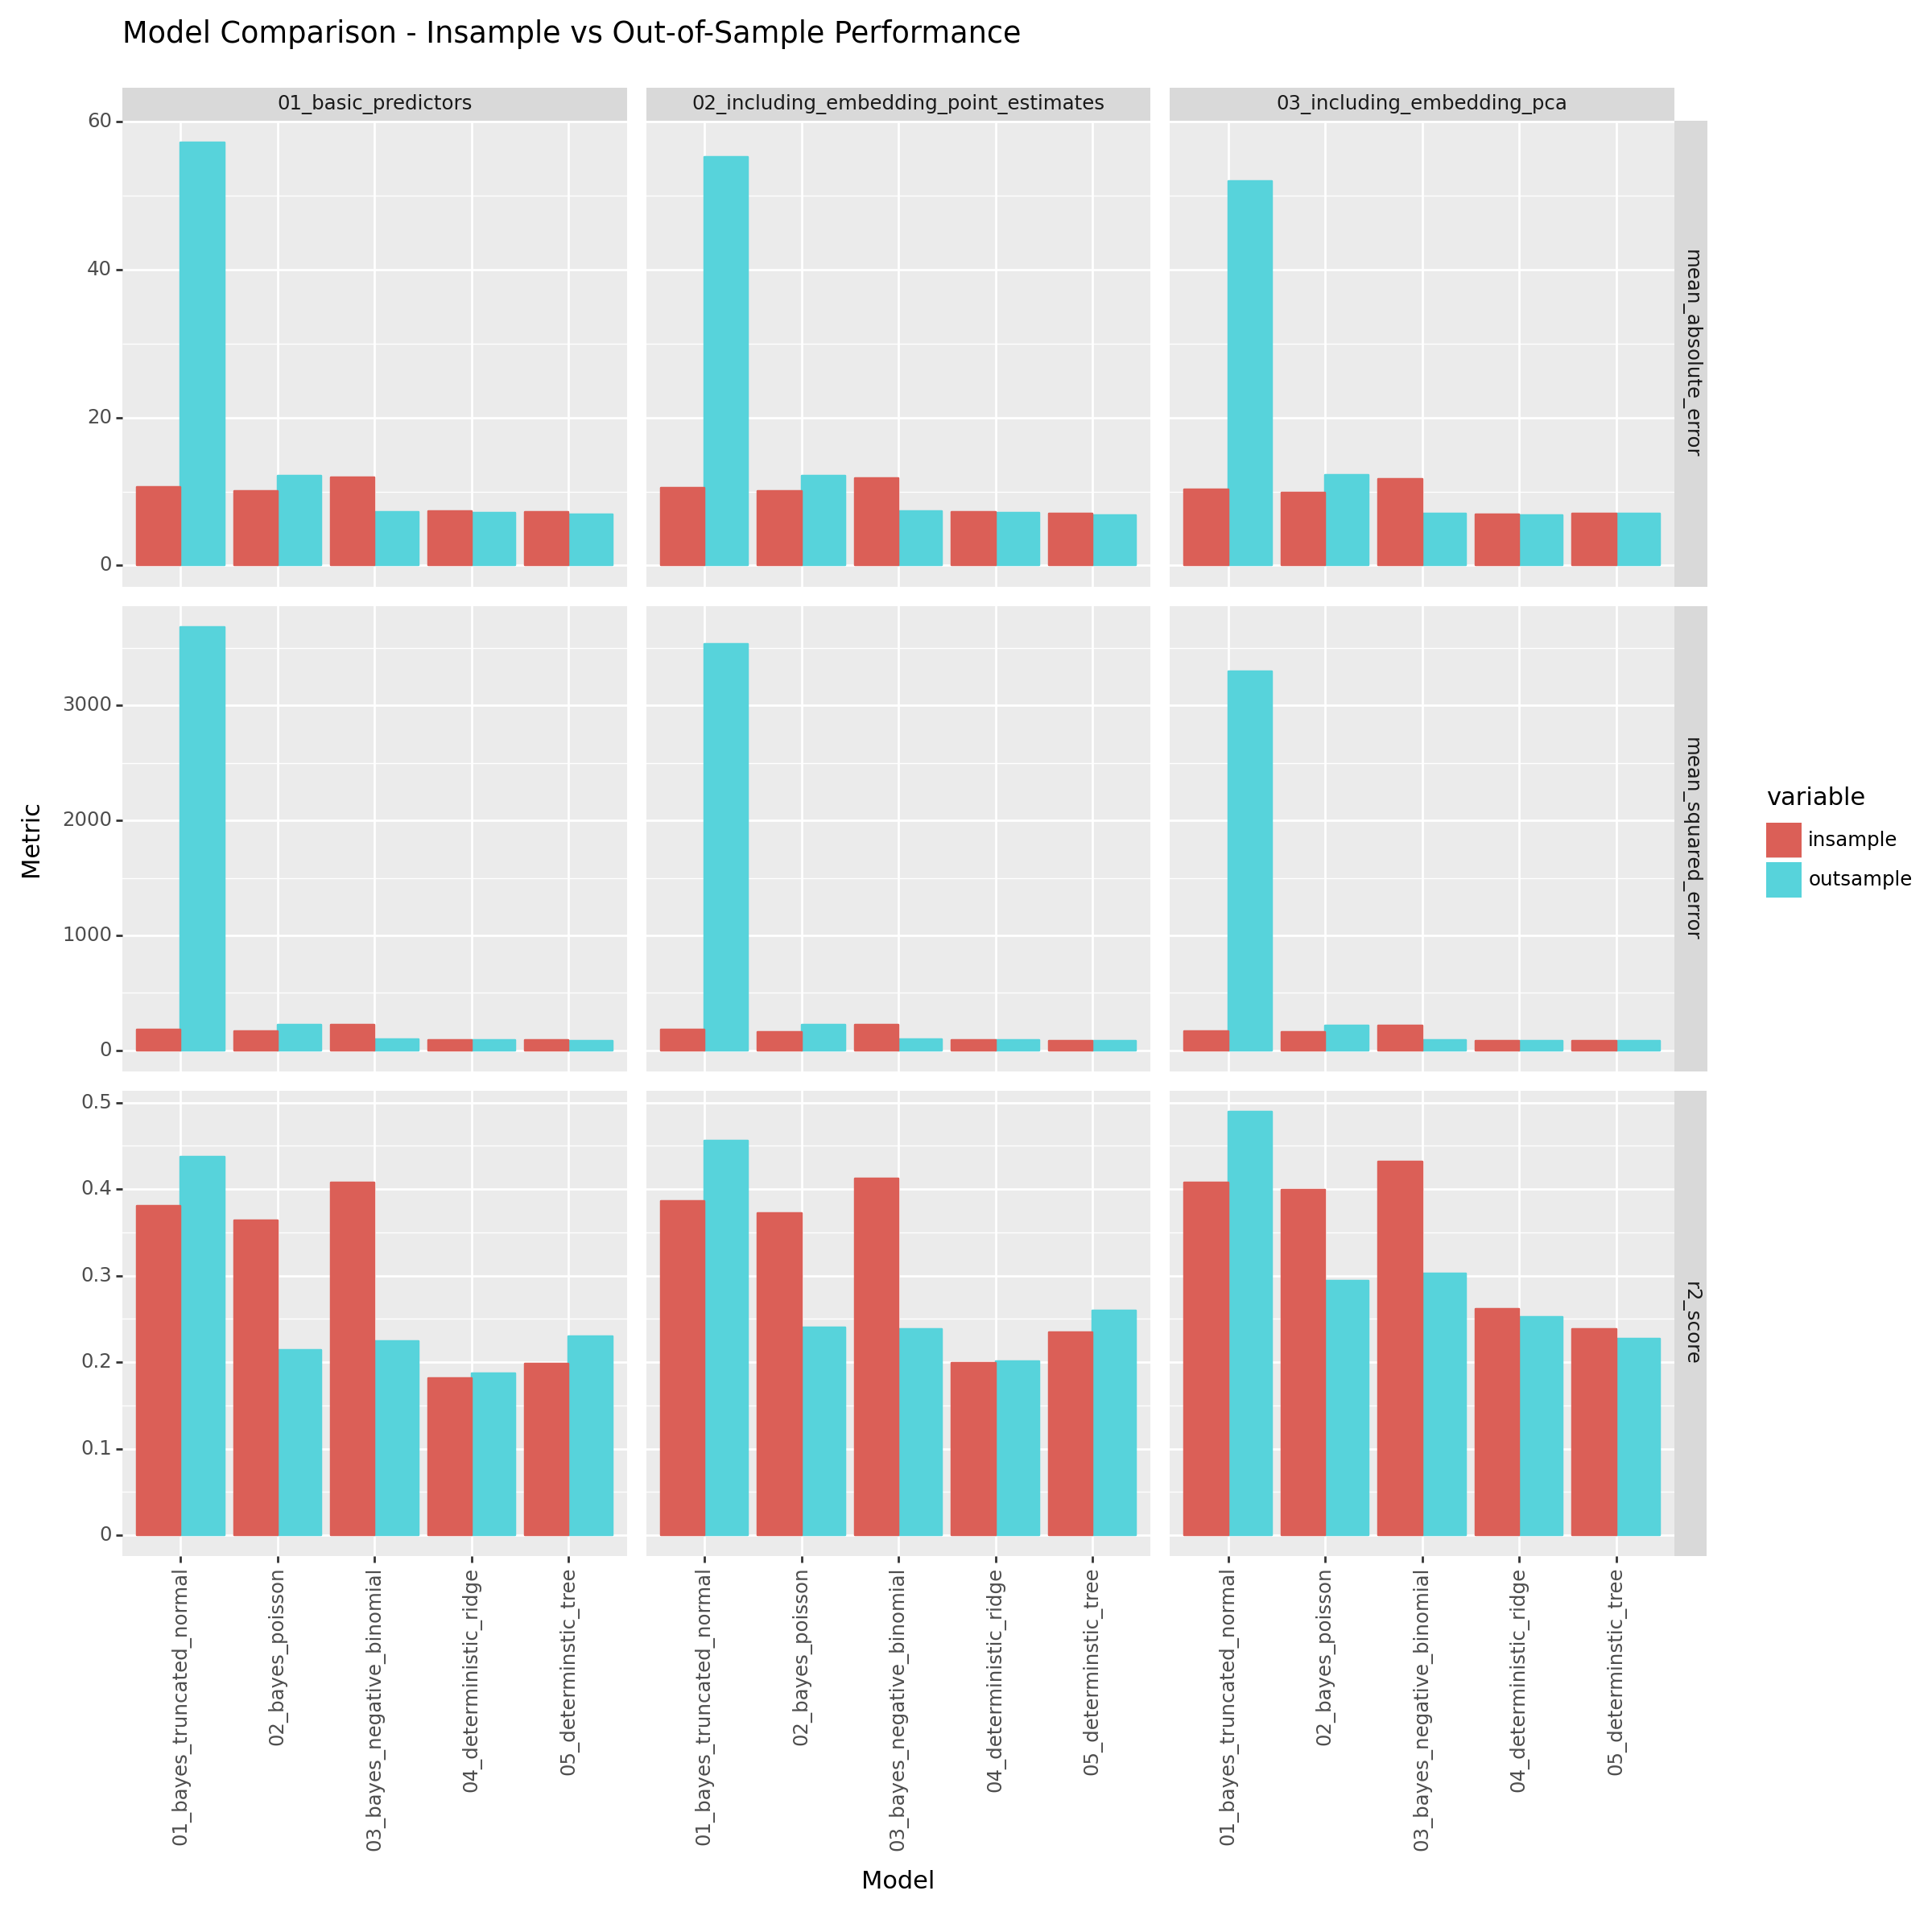

<Figure Size: (1200 x 1200)>

In [210]:
(
    pn.ggplot(final_comparison_df,
              pn.aes(x = 'model_id', y = 'value', fill = 'variable', color = 'variable', group = 'variable'))
    + pn.geom_col(position = 'dodge')
    + pn.facet_grid('metric ~ dataset_id', scales = 'free')
    + pn.theme(axis_text_x = pn.element_text(angle = 90),
               figure_size = (12, 12))
    + pn.labs(x = 'Model', y = 'Metric', title = 'Model Comparison - Insample vs Out-of-Sample Performance')
)

In [211]:
final_comparison_df[['dataset_id', 'model_id', 'metric', 'variable', 'value']].pivot(
    index = ['dataset_id', 'metric'], columns = ['model_id', 'variable']
)

value  \
model_id                                                   01_bayes_truncated_normal   
variable                                                                    insample   
dataset_id                             metric                                          
01_basic_predictors                    mean_absolute_error                 10.647059   
                                       mean_squared_error                 181.239931   
                                       r2_score                             0.380364   
02_including_embedding_point_estimates mean_absolute_error                 10.540960   
                                       mean_squared_error                 177.428922   
                                       r2_score                             0.385891   
03_including_embedding_pca             mean_absolute_error                 10.225261   
                                       mean_squared_error                 167.579763   
                                       r2_score                             0.407437   

                                                                         \
model_id                                                                  
variable                                                      outsample   
dataset_id                             metric                             
01_basic_predictors                    mean_absolute_error    57.251721   
                                       mean_squared_error   3682.106036   
                                       r2_score                0.437425   
02_including_embedding_point_estimates mean_absolute_error    55.212844   
                                       mean_squared_error   3533.769933   
                                       r2_score                0.456015   
03_including_embedding_pca             mean_absolute_error    51.961080   
                                       mean_squared_error   3296.528490   
                                       r2_score                0.489022   

                                                                             \
model_id                                                   02_bayes_poisson   
variable                                                           insample   
dataset_id                             metric                                 
01_basic_predictors                    mean_absolute_error        10.081828   
                                       mean_squared_error        163.022123   
                                       r2_score                    0.363694   
02_including_embedding_point_estimates mean_absolute_error        10.033327   
                                       mean_squared_error        160.976464   
                                       r2_score                    0.372040   
03_including_embedding_pca             mean_absolute_error         9.865944   
                                       mean_squared_error        156.194289   
                                       r2_score                    0.398980   

                                                                        \
model_id                                                                 
variable                                                     outsample   
dataset_id                             metric                            
01_basic_predictors                    mean_absolute_error   12.133047   
                                       mean_squared_error   222.530758   
                                       r2_score               0.214248   
02_including_embedding_point_estimates mean_absolute_error   12.124464   
                                       mean_squared_error   219.709585   
                                       r2_score               0.239974   
03_including_embedding_pca             mean_absolute_error   12.200286   
                                       mean_squared_error   217.133047   
                                       r2_

In [ ]:
!pip freeze > /content/requirements.txt